# Proyecto final - Minería de Datos
### Alejandro Carregha, Eduardo Don Pablo y José Salvador Abascal

## Descripción del Dataset

Una compañía de seguros médicos ha puesto a disposición un conjunto de datos que reúne información de aproximadamente 1,000 clientes. El objetivo principal de este dataset es permitir el desarrollo de un modelo predictivo capaz de estimar el costo anual del seguro médico (Price Premium of the insurance in USD) para cada cliente.

Es importante destacar que los datos han sido proporcionados de manera voluntaria por los clientes, lo que significa que la información reflejada en el conjunto es representativa de personas reales y sus condiciones de salud, permitiendo realizar análisis confiables y útiles para el diseño de modelos de riesgo, segmentación de clientes y optimización de precios.

### Variables del dataset:
- **Age**: Edad del cliente. Representa un factor crucial para las aseguradoras, ya que el riesgo médico suele aumentar con la edad.
- **Diabetes:**: Indica si la persona presenta niveles anormales de azúcar en la sangre. Este factor incrementa el riesgo y suele influir en un costo mayor del seguro debido a posibles complicaciones médicas.
- **BloodPressureProblems**: Señala si el individuo tiene problemas de presión arterial. La hipertensión es un factor de riesgo importante y comúnmente asociado a tratamientos médicos frecuentes.
- **AnyTransplants**: Indica si el cliente ha pasado por un trasplante de órgano mayor. Este tipo de procedimientos implica un historial médico de alto riesgo y puede incrementar significativamente el costo de la póliza.
- **AnyChronicDiseases**: Indica si el cliente padece alguna enfermedad crónica como asma, artritis, entre otras. Las condiciones crónicas suelen requerir tratamientos continuos, lo que impacta el cálculo del seguro.
- **Height**: Altura del cliente. Se usa principalmente junto con el peso para calcular indicadores como el índice de masa corporal (IMC), útil para identificar riesgo relacionado con sobrepeso u obesidad.
- **Weight**: Peso del cliente. Contribuye a estimar la condición física del individuo y evaluar riesgos asociados a hábitos de salud y posibles enfermedades.
- **KnownAllergies**: Señala si el cliente tiene alergias conocidas. Esto puede incluir alergias alimentarias, a medicamentos o ambientales, y aunque no siempre implica un alto riesgo, sí puede influir en el precio dependiendo de la severidad.
- **HistoryOfCancerInFamily**: Indica si algún familiar directo del cliente ha tenido algún tipo de cáncer. Un historial familiar positivo puede elevar la probabilidad de enfermedades hereditarias, lo cual es relevante para modelos de riesgo.
- **NumberOfMajorSurgeries**: Número de cirugías mayores que el cliente ha tenido. Un historial quirúrgico amplio suele estar asociado con mayores costos médicos y seguimiento especializado.

##### Variable objetivo:
- **PriceUSD**: Es la variable objetivo del dataset. Representa el precio anual del seguro médico en dólares estadounidenses para cada cliente, calculado en función de las variables anteriores.

### 1. Importar datos:

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import warnings
from catboost import CatBoostRegressor
import time
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [162]:
# Descargar y leer el dataset
data = pd.read_csv("Medicalpremium.csv")

print("Dataset cargado exitosamente!")
print(f"Dimensiones del dataset: {data.shape}")
print(f"Columnas: {data.columns.tolist()}")

Dataset cargado exitosamente!
Dimensiones del dataset: (986, 11)
Columnas: ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice']


### 2. Análisis exploratorio de datos (EDA):

In [163]:
# Cambio de moneda (rupias a dólares)
data['PriceUSD'] = data['PremiumPrice']*0.011
del data['PremiumPrice']

# Primeras filas del dataset
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PriceUSD
0,45,0,0,0,0,155,57,0,0,0,275.0
1,60,1,0,0,0,180,73,0,0,0,319.0
2,36,1,1,0,0,158,59,0,0,1,253.0
3,52,1,1,0,1,183,93,0,0,2,308.0
4,38,0,0,0,1,166,88,0,0,1,253.0


In [164]:
# Información general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      986 non-null    int64  
 1   Diabetes                 986 non-null    int64  
 2   BloodPressureProblems    986 non-null    int64  
 3   AnyTransplants           986 non-null    int64  
 4   AnyChronicDiseases       986 non-null    int64  
 5   Height                   986 non-null    int64  
 6   Weight                   986 non-null    int64  
 7   KnownAllergies           986 non-null    int64  
 8   HistoryOfCancerInFamily  986 non-null    int64  
 9   NumberOfMajorSurgeries   986 non-null    int64  
 10  PriceUSD                 986 non-null    float64
dtypes: float64(1), int64(10)
memory usage: 84.9 KB


In [165]:
# Estadísticas descriptivas
data.describe().round(2)

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PriceUSD
count,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00
mean,41.75,0.42,0.47,0.06,0.18,168.18,76.95,0.22,0.12,0.67,267.70
std,13.96,0.49,0.50,0.23,0.38,10.10,14.27,0.41,0.32,0.75,68.73
min,18.00,0.00,0.00,0.00,0.00,145.00,51.00,0.00,0.00,0.00,165.00
25%,30.00,0.00,0.00,0.00,0.00,161.00,67.00,0.00,0.00,0.00,231.00
50%,42.00,0.00,0.00,0.00,0.00,168.00,75.00,0.00,0.00,1.00,253.00
75%,53.00,1.00,1.00,0.00,0.00,176.00,87.00,0.00,0.00,1.00,308.00
max,66.00,1.00,1.00,1.00,1.00,188.00,132.00,1.00,1.00,3.00,440.00


In [166]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())

Valores nulos por columna:
Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PriceUSD                   0
dtype: int64


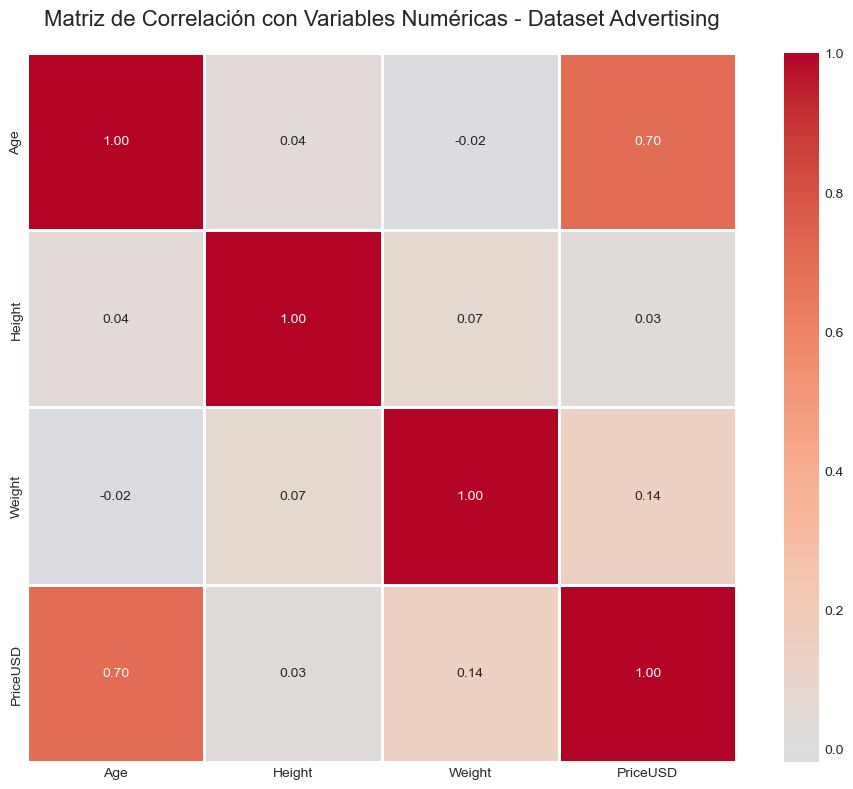

In [167]:
vars_num = data.loc[:,['Age','Height','Weight','PriceUSD']]
# Matriz de correlación con variables numéricas
correlation_matrix = vars_num.corr()
# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Matriz de Correlación con Variables Numéricas - Dataset Advertising', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

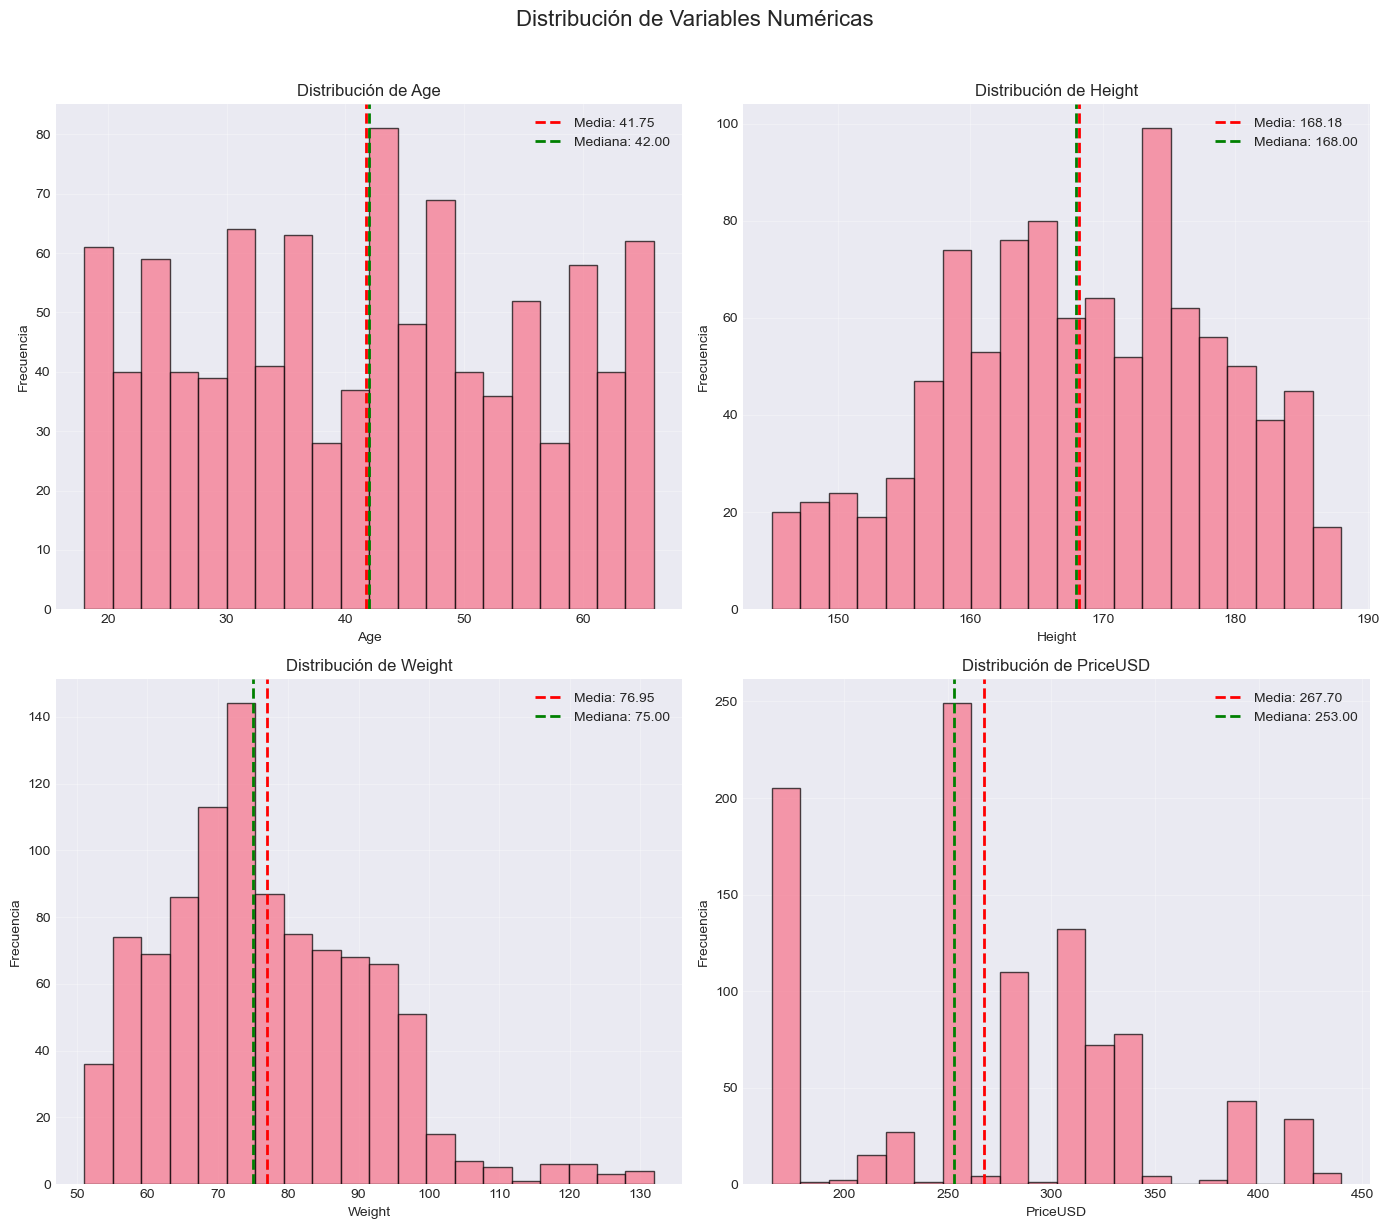

In [168]:
# Distribución de las variables
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Distribución de Variables Numéricas', fontsize=16, y=1.02)

variables = vars_num

for idx, (ax, var) in enumerate(zip(axes.flat, variables)):
    ax.hist(data[var], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribución de {var}', fontsize=12)
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')
    ax.grid(True, alpha=0.3)
    
    # Agregar estadísticas
    mean_val = data[var].mean()
    median_val = data[var].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

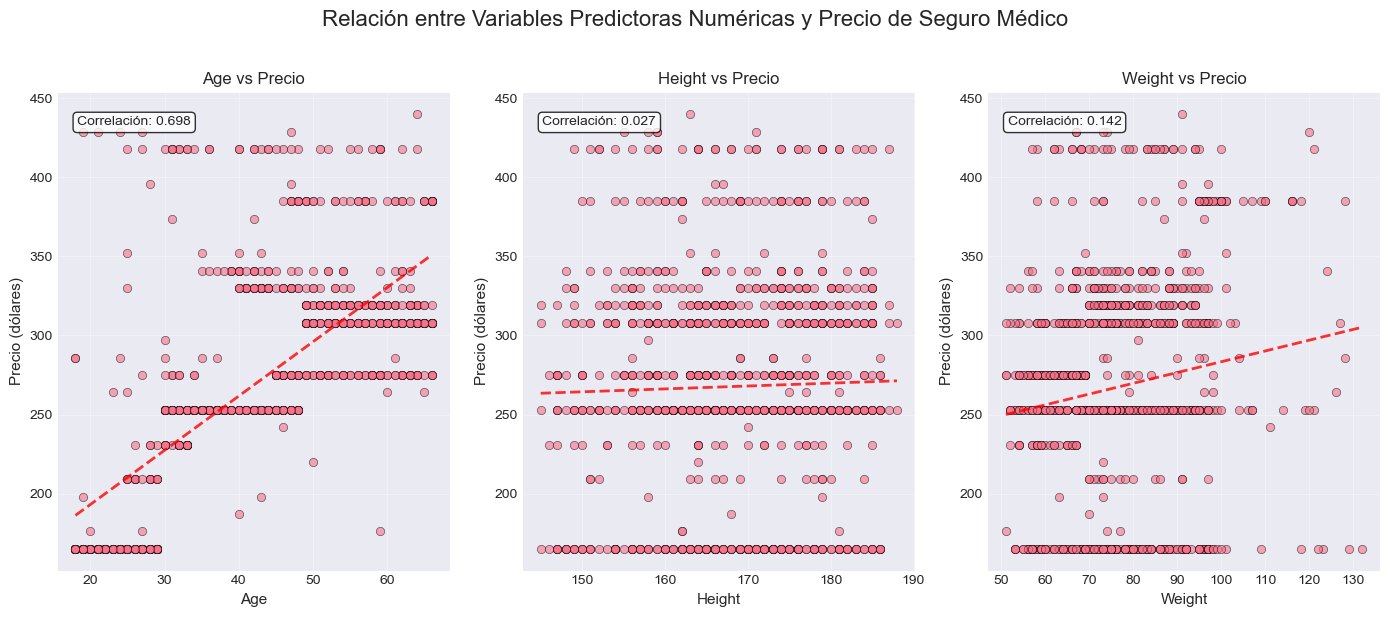

In [169]:
# Relación entre cada variable predictora y las ventas
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Relación entre Variables Predictoras Numéricas y Precio de Seguro Médico', fontsize=16, y=1.02)

predictors = vars_num
axes = axes.flatten()

for ax, predictor in zip(axes, predictors):
    ax.scatter(data[predictor], data['PriceUSD'], alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.set_xlabel(f'{predictor}', fontsize=11)
    ax.set_ylabel('Precio (dólares)', fontsize=11)
    ax.set_title(f'{predictor} vs Precio', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Agregar línea de tendencia
    z = np.polyfit(data[predictor], data['PriceUSD'], 1)
    p = np.poly1d(z)
    ax.plot(data[predictor].sort_values(), p(data[predictor].sort_values()), 
            "r--", alpha=0.8, linewidth=2)
    
    # Agregar correlación
    corr = data[[predictor, 'PriceUSD']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'Correlación: {corr:.3f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

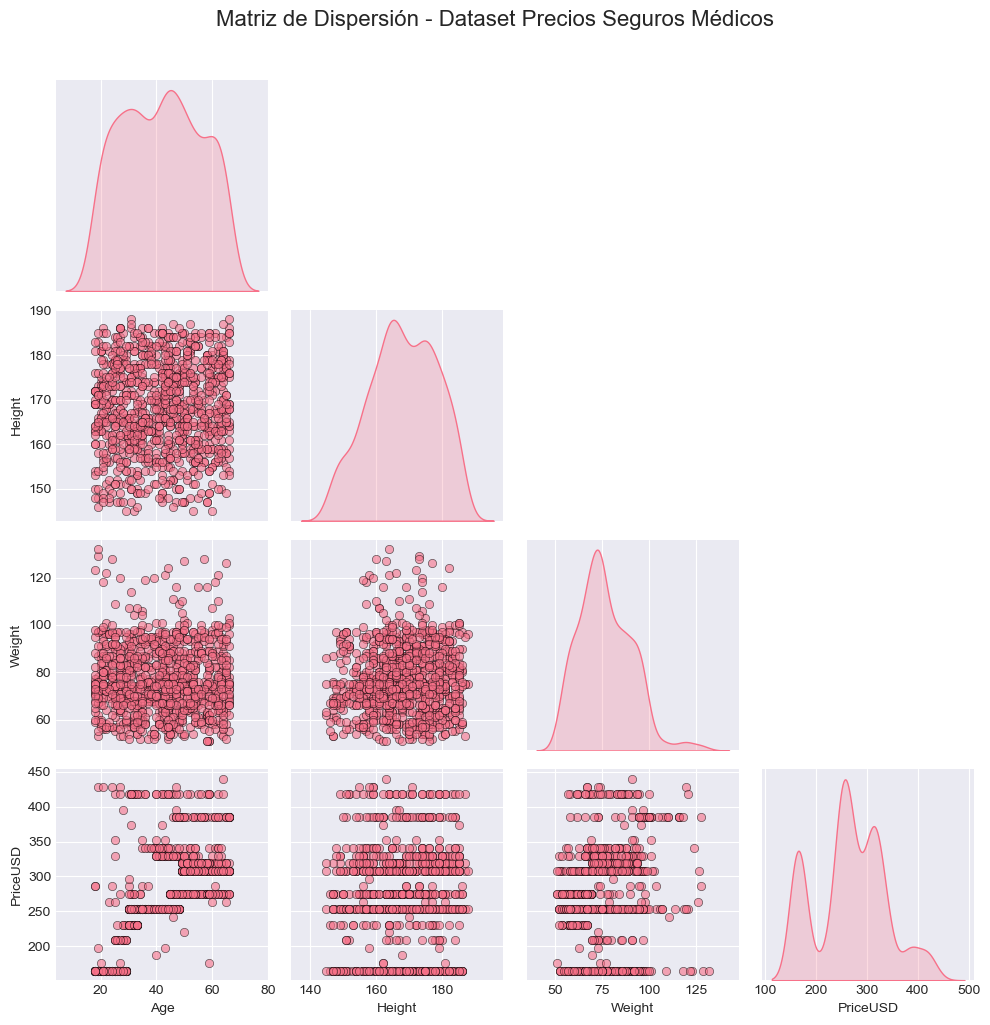

In [170]:
# Pairplot para visualizar todas las relaciones
plt.figure(figsize=(12, 10))
sns.pairplot(vars_num, diag_kind='kde', corner=True, 
             plot_kws={'alpha': 0.6, 'edgecolor': 'black', 'linewidth': 0.5})
plt.suptitle('Matriz de Dispersión - Dataset Precios Seguros Médicos', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [171]:
def calcular_phi_coefficient(serie1, serie2):
    """
    Calcula el coeficiente Phi (φ) entre dos variables categóricas.
    
    El coeficiente Phi es una medida de asociación basada en chi-cuadrado:
    φ = √(χ² / n)
    
    Valores:
    - φ = 0: No hay asociación
    - φ = 1 o -1: Asociación perfecta
    - φ cercano a 0: Asociación débil
    """
    # Eliminar valores nulos
    mask = ~(serie1.isna() | serie2.isna())
    s1 = serie1[mask]
    s2 = serie2[mask]
    
    if len(s1) == 0:
        return 0.0, 1.0  # phi, p-value
    
    # Crear tabla de contingencia
    tabla_contingencia = pd.crosstab(s1, s2)
    
    # Calcular chi-cuadrado
    chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia)
    
    # Calcular Phi
    n = len(s1)
    phi = np.sqrt(chi2 / n)
    
    # Para tablas más grandes que 2x2, ajustar con Cramér's V
    r, k = tabla_contingencia.shape
    if r > 2 or k > 2:
        # Cramér's V
        phi = np.sqrt(chi2 / (n * min(r - 1, k - 1)))
    
    return phi, p_value


def calcular_matriz_phi(df, columnas):
    """
    Calcula la matriz de coeficientes Phi para todas las combinaciones
    de columnas categóricas.
    
    Returns:
        matriz_phi: Matriz de coeficientes Phi
        matriz_pvalues: Matriz de p-values
    """
    n = len(columnas)
    matriz_phi = np.ones((n, n))  # Diagonal es 1
    matriz_pvalues = np.zeros((n, n))
    
    # Calcular para cada par de columnas
    for i, col1 in enumerate(columnas):
        for j, col2 in enumerate(columnas):
            if i != j:
                phi, p_value = calcular_phi_coefficient(df[col1], df[col2])
                matriz_phi[i, j] = phi
                matriz_pvalues[i, j] = p_value
    
    return matriz_phi, matriz_pvalues


def visualizar_phi(matriz_phi, matriz_pvalues, nombres_columnas, alpha=0.05):
    """
    Crea visualizaciones de la matriz de coeficientes Phi.
    """
    # Crear figura con tres subplots
    fig = plt.figure(figsize=(9, 20))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    
    # 1. Heatmap del coeficiente Phi
    sns.heatmap(matriz_phi, 
                annot=True, 
                fmt='.3f', 
                cmap='coolwarm', 
                center=0,
                xticklabels=nombres_columnas,
                yticklabels=nombres_columnas,
                cbar_kws={'label': 'Coeficiente Phi (φ)'},
                ax=ax1,
                vmin=0,
                vmax=1)
    ax1.set_title('Coeficiente Phi (φ)\n(Fuerza de Asociación entre Variables Categóricas)', 
                  fontsize=13, fontweight='bold', pad=15)
    ax1.set_xlabel('Variables', fontsize=11)
    ax1.set_ylabel('Variables', fontsize=11)
    
    # 2. Heatmap de significancia estadística
    significancia = matriz_pvalues < alpha
    matriz_sig_visual = np.where(significancia, matriz_phi, 0)
    np.fill_diagonal(matriz_sig_visual, 1)
    
    sns.heatmap(matriz_sig_visual, 
                annot=matriz_pvalues, 
                fmt='.4f', 
                cmap='YlGn', 
                xticklabels=nombres_columnas,
                yticklabels=nombres_columnas,
                cbar_kws={'label': 'Phi (solo asociaciones significativas)'},
                ax=ax2,
                vmin=0,
                vmax=1)
    ax2.set_title(f'Significancia Estadística\n(p < {alpha})', 
                  fontsize=13, fontweight='bold', pad=15)
    ax2.set_xlabel('Variables', fontsize=11)
    ax2.set_ylabel('Variables', fontsize=11)
    
    # 3. Gráfico de barras para pares de variables
    pares = []
    valores_phi = []
    valores_p = []
    
    for i in range(len(nombres_columnas)):
        for j in range(i+1, len(nombres_columnas)):
            pares.append(f"{nombres_columnas[i]}\n{nombres_columnas[j]}")
            valores_phi.append(matriz_phi[i, j])
            valores_p.append(matriz_pvalues[i, j])
    
    # Ordenar por valor de Phi
    indices_ordenados = np.argsort(valores_phi)[::-1]
    pares_ordenados = [pares[i] for i in indices_ordenados]
    valores_phi_ordenados = [valores_phi[i] for i in indices_ordenados]
    valores_p_ordenados = [valores_p[i] for i in indices_ordenados]
    
    # Colores según significancia
    colores = ['green' if p < alpha else 'lightcoral' for p in valores_p_ordenados]
    
    barras = ax3.barh(pares_ordenados, valores_phi_ordenados, color=colores, alpha=0.7)
    ax3.set_xlabel('Coeficiente Phi (φ)', fontsize=11)
    ax3.set_title('Asociación entre Pares de Variables Categóricas\n(Verde: p < 0.05, Rojo: p ≥ 0.05)', 
                  fontsize=13, fontweight='bold', pad=15)
    ax3.set_xlim(0, max(valores_phi_ordenados) * 1.15)
    ax3.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for i, (barra, valor_phi, valor_p) in enumerate(zip(barras, valores_phi_ordenados, valores_p_ordenados)):
        ax3.text(valor_phi + 0.01, i, f'{valor_phi:.3f}\n(p={valor_p:.4f})', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return fig


def interpretar_phi(phi):
    """
    Interpreta el valor del coeficiente Phi.
    """
    phi_abs = abs(phi)
    if phi_abs < 0.1:
        return "Muy débil o ninguna"
    elif phi_abs < 0.3:
        return "Débil"
    elif phi_abs < 0.5:
        return "Moderada"
    elif phi_abs < 0.7:
        return "Fuerte"
    else:
        return "Muy fuerte"
    
def preparar_phi_dataset(df, indices_columnas, alpha=0.05):
    """
    Solo calcula todo lo necesario para el análisis Phi
    y regresa un diccionario con los objetos listos para explorarse.
    """
    nombres_columnas = [df.columns[i] for i in indices_columnas]

    # Calcular matrices de Phi y p-values
    matriz_phi, matriz_pvalues = calcular_matriz_phi(df, [df.columns[i] for i in indices_columnas])

    # DataFrames
    df_phi = pd.DataFrame(matriz_phi, 
                          index=nombres_columnas, 
                          columns=nombres_columnas)
    
    df_pvalues = pd.DataFrame(matriz_pvalues,
                              index=nombres_columnas,
                              columns=nombres_columnas)

    # Armar tabla de resultados detallados
    resultados = []
    for i in range(len(nombres_columnas)):
        for j in range(i+1, len(nombres_columnas)):
            phi = matriz_phi[i, j]
            p_val = matriz_pvalues[i, j]
            significativo = "Sí" if p_val < alpha else "No"
            interpretacion = interpretar_phi(phi)
            
            resultados.append({
                'Par': f"{nombres_columnas[i]} - {nombres_columnas[j]}",
                'Phi': phi,
                'P-value': p_val,
                'Significativo': significativo,
                'Interpretación': interpretacion
            })
    
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('Phi', ascending=False)

    asociaciones_sig = df_resultados[df_resultados['Significativo'] == 'Sí']

    return {
        "nombres_columnas": nombres_columnas,
        "matriz_phi": matriz_phi,
        "matriz_pvalues": matriz_pvalues,
        "df_phi": df_phi,
        "df_pvalues": df_pvalues,
        "df_resultados": df_resultados,
        "asociaciones_sig": asociaciones_sig,
        "alpha": alpha,
        "n_filas": df.shape[0],
        "n_columnas": df.shape[1],
        "indices_columnas": indices_columnas
    }

from IPython.display import display

def reporte_phi_resumen(info, df):
    """
    Resumen general del análisis: dimensiones del dataset,
    nivel de significancia y una tabla compacta con la info 
    de cada variable categórica (en lugar de muchos prints).
    """
    nombres_columnas = info["nombres_columnas"]
    alpha = info["alpha"]
    n_filas = info["n_filas"]
    n_columnas = info["n_columnas"]
    
    # Encabezado muy breve (poco texto para no disparar el límite)
    print("="*70)
    print("ANÁLISIS DE COEFICIENTES PHI (φ)")
    print("="*70)
    print(f"Dataset: {n_filas} filas × {n_columnas} columnas")
    print(f"Nivel de significancia: α = {alpha}")
    print(f"Columnas analizadas: {', '.join(nombres_columnas)}")
    print("\nResumen de variables categóricas:\n")

    # Construimos una tabla compacta con la info por variable
    filas_resumen = []
    for col in nombres_columnas:
        valores_unicos = df[col].nunique()
        valores_nulos = df[col].isna().sum()
        pct_nulos = valores_nulos / n_filas * 100
        
        vc = df[col].value_counts()
        top1_cat = vc.index[0]
        top1_cnt = vc.iloc[0]
        
        if len(vc) > 1:
            top2_cat = vc.index[1]
            top2_cnt = vc.iloc[1]
        else:
            top2_cat = None
            top2_cnt = 0
        
        filas_resumen.append({
            "Variable": col,
            "Categorías únicas": valores_unicos,
            "Nulos": valores_nulos,
            "% Nulos": round(pct_nulos, 2),
            "Top1 categoría": top1_cat,
            "Top1 conteo": top1_cnt,
            "Top2 categoría": top2_cat,
            "Top2 conteo": top2_cnt
        })
    
    df_resumen = pd.DataFrame(filas_resumen)

    # Mostrar como tabla (mucho más compacto que muchos prints)
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 0,
                           'display.max_colwidth', None):
        display(df_resumen)

def mostrar_matrices_phi(info):
    """
    Muestra únicamente las matrices df_phi y df_pvalues, 
    usando display y opción de ver todas las filas/columnas.
    """
    df_phi = info["df_phi"]
    df_pvalues = info["df_pvalues"]

    print("\n" + "-"*70)
    print("Matriz de Coeficientes Phi (φ):")
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 0,
                           'display.max_colwidth', None):
        display(df_phi.round(3))

    print("\nMatriz de P-values:")
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 0,
                           'display.max_colwidth', None):
        display(df_pvalues.round(4))


def mostrar_resultados_phi(info):
    """
    Muestra la tabla de asociaciones (df_resultados) y el resumen final.
    """
    df_resultados = info["df_resultados"]
    asociaciones_sig = info["asociaciones_sig"]
    alpha = info["alpha"]

    print("\n" + "-"*70)
    print("ANÁLISIS DETALLADO DE ASOCIACIONES:")
    print("-"*70)
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.width', 0,
                           'display.max_colwidth', None):
        display(df_resultados)

    # Resumen
    print("\n" + "="*70)
    print("RESUMEN:")
    print("="*70)
    print(f"\nTotal de pares analizados: {len(df_resultados)}")
    print(f"Asociaciones estadísticamente significativas (p < {alpha}): {len(asociaciones_sig)}")

    if len(asociaciones_sig) > 0:
        print(f"\nAsociación MÁS FUERTE:")
        max_row = asociaciones_sig.iloc[0]
        print(f"  {max_row['Par']}")
        print(f"  φ = {max_row['Phi']:.3f} (p = {max_row['P-value']:.4f})")
        print(f"  Interpretación: {max_row['Interpretación']}")


def graficas_phi(info):
    """
    Solo genera las gráficas a partir del diccionario `info`.
    """
    visualizar_phi(
        info["matriz_phi"],
        info["matriz_pvalues"],
        info["nombres_columnas"],
        alpha=info["alpha"]
    )

In [172]:
info_phi = preparar_phi_dataset(
    data,                
    indices_columnas=[1, 2, 3, 4, 7, 8],
    alpha=0.05
)

In [173]:
reporte_phi_resumen(info_phi, data)

ANÁLISIS DE COEFICIENTES PHI (φ)
Dataset: 986 filas × 11 columnas
Nivel de significancia: α = 0.05
Columnas analizadas: Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, KnownAllergies, HistoryOfCancerInFamily

Resumen de variables categóricas:



,Variable,Categorías únicas,Nulos,% Nulos,Top1 categoría,Top1 conteo,Top2 categoría,Top2 conteo
0,Diabetes,2,0,0.0,0,572,1,414
1,BloodPressureProblems,2,0,0.0,0,524,1,462
2,AnyTransplants,2,0,0.0,0,931,1,55
3,AnyChronicDiseases,2,0,0.0,0,808,1,178
4,KnownAllergies,2,0,0.0,0,774,1,212
5,HistoryOfCancerInFamily,2,0,0.0,0,870,1,116


In [174]:
mostrar_matrices_phi(info_phi)


----------------------------------------------------------------------
Matriz de Coeficientes Phi (φ):


,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily
Diabetes,1.000,0.126,0.032,0.087,0.078,0.052
BloodPressureProblems,0.126,1.000,0.020,0.043,0.009,0.045
AnyTransplants,0.032,0.020,1.000,0.030,0.000,0.013
AnyChronicDiseases,0.087,0.043,0.030,1.000,0.024,0.005
KnownAllergies,0.078,0.009,0.000,0.024,1.000,0.112
HistoryOfCancerInFamily,0.052,0.045,0.013,0.005,0.112,1.000



Matriz de P-values:


,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily
Diabetes,0.0000,0.0001,0.3123,0.0064,0.0148,0.1003
BloodPressureProblems,0.0001,0.0000,0.5277,0.1791,0.7756,0.1569
AnyTransplants,0.3123,0.5277,0.0000,0.3536,1.0000,0.6759
AnyChronicDiseases,0.0064,0.1791,0.3536,0.0000,0.4472,0.8858
KnownAllergies,0.0148,0.7756,1.0000,0.4472,0.0000,0.0005
HistoryOfCancerInFamily,0.1003,0.1569,0.6759,0.8858,0.0005,0.0000


In [175]:
mostrar_resultados_phi(info_phi)


----------------------------------------------------------------------
ANÁLISIS DETALLADO DE ASOCIACIONES:
----------------------------------------------------------------------


,Par,Phi,P-value,Significativo,Interpretación
0,Diabetes - BloodPressureProblems,0.125667,0.000079,Sí,Débil
14,KnownAllergies - HistoryOfCancerInFamily,0.111552,0.000460,Sí,Débil
2,Diabetes - AnyChronicDiseases,0.086757,0.006445,Sí,Muy débil o ninguna
3,Diabetes - KnownAllergies,0.077601,0.014821,Sí,Muy débil o ninguna
4,Diabetes - HistoryOfCancerInFamily,0.052338,0.100292,No,Muy débil o ninguna
8,BloodPressureProblems - HistoryOfCancerInFamily,0.045085,0.156867,No,Muy débil o ninguna
6,BloodPressureProblems - AnyChronicDiseases,0.042782,0.179146,No,Muy débil o ninguna
1,Diabetes - AnyTransplants,0.032175,0.312346,No,Muy débil o ninguna
9,AnyTransplants - AnyChronicDiseases,0.029540,0.353633,No,Muy débil o ninguna
12,AnyChronicDiseases - KnownAllergies,0.024209,0.447153,No,Muy débil o ninguna



RESUMEN:

Total de pares analizados: 15
Asociaciones estadísticamente significativas (p < 0.05): 4

Asociación MÁS FUERTE:
  Diabetes - BloodPressureProblems
  φ = 0.126 (p = 0.0001)
  Interpretación: Débil


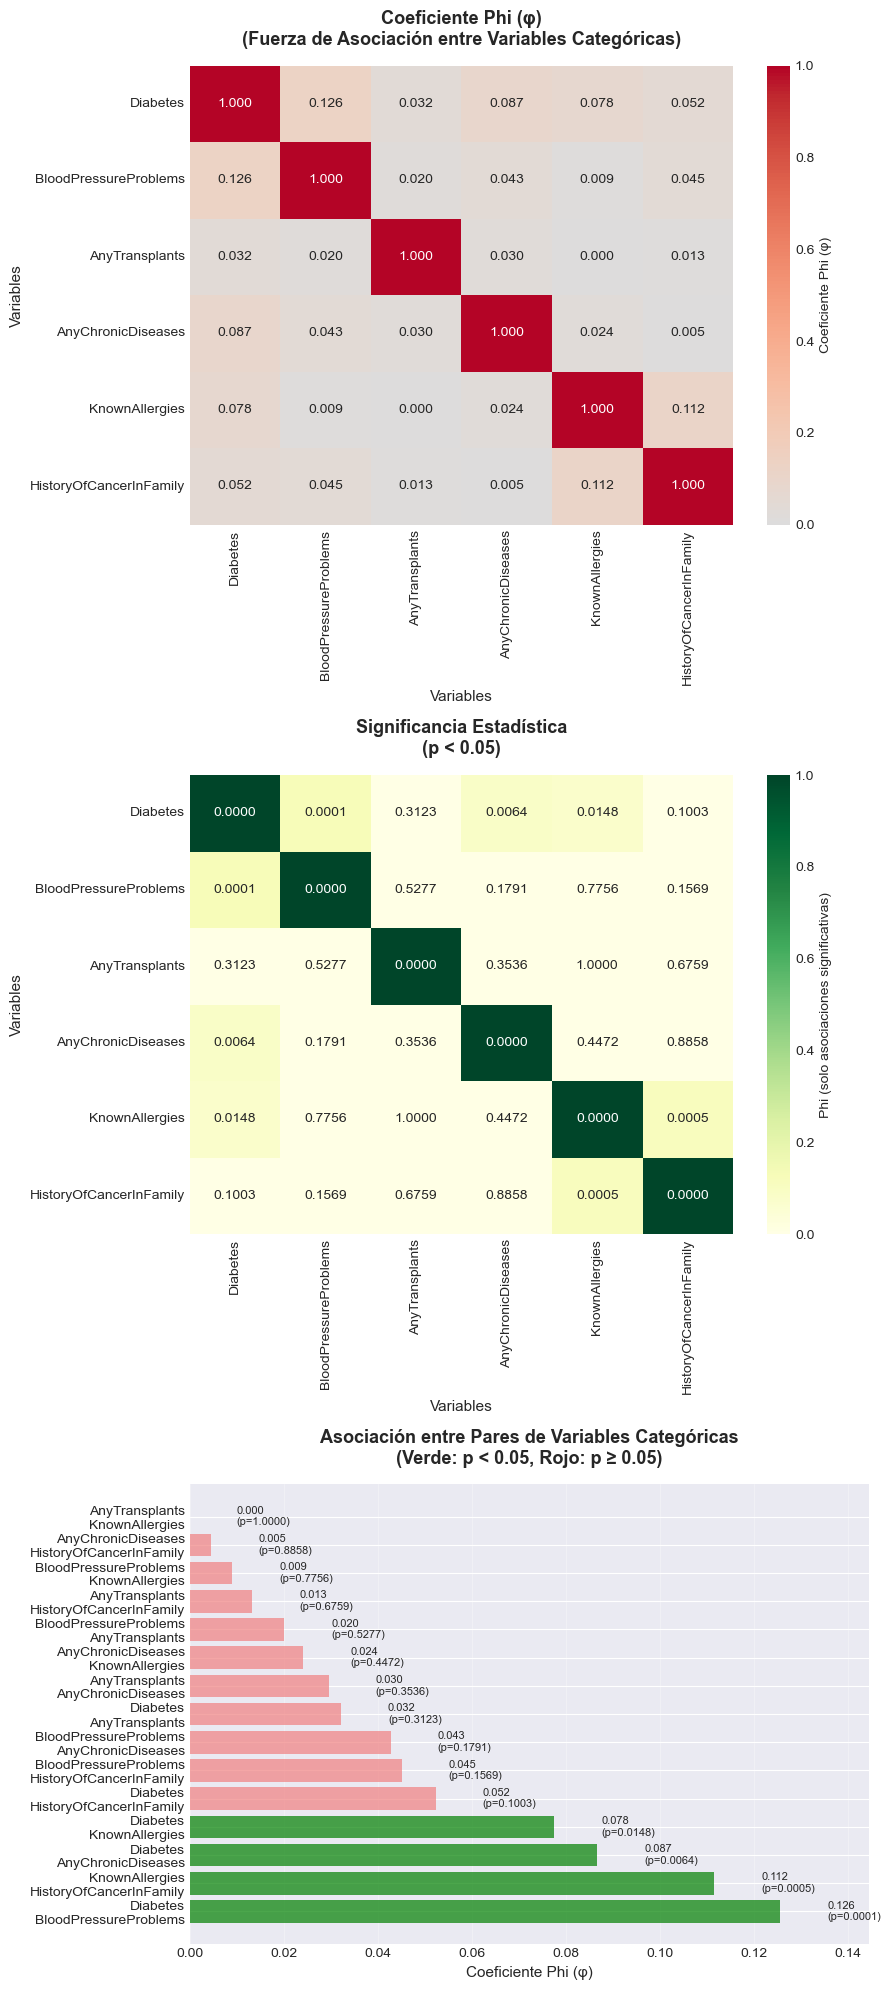

In [176]:
graficas_phi(info_phi)

### 3. Train-test split:

In [229]:
# Preparación de datos para el modelado
# Separar features y target
X = data.drop('PriceUSD', axis=1)
y = data['PriceUSD']

print("="*70)
print("PREPARACIÓN DE DATOS PARA PREDICCIÓN")
print("="*70)
print(f"\nDimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"\nVariables predictoras:")
print(f"  • Numéricas: {X.select_dtypes(include=[np.number]).columns.tolist()}")
print(f"  • Categóricas: {X.select_dtypes(include=['object']).columns.tolist()}")
print(f"\nVariable objetivo (PriceUSD):")
print(f"  • Mínimo: ${y.min():.2f}")
print(f"  • Máximo: ${y.max():.2f}")
print(f"  • Media: ${y.mean():.2f}")
print(f"  • Desviación estándar: ${y.std():.2f}")

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

print(f"\nDivisión de datos:")
print(f"  • Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

PREPARACIÓN DE DATOS PARA PREDICCIÓN

Dimensiones de X: (986, 10)
Dimensiones de y: (986,)

Variables predictoras:
  • Numéricas: ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
  • Categóricas: []

Variable objetivo (PriceUSD):
  • Mínimo: $165.00
  • Máximo: $440.00
  • Media: $267.70
  • Desviación estándar: $68.73

División de datos:
  • Conjunto de entrenamiento: 788 muestras (79.9%)
  • Conjunto de prueba: 198 muestras (20.1%)


In [269]:
# Estandarización de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos estandarizados para Ridge, Lasso y Elastic Net")
print(f"Media de X_train_scaled: {X_train_scaled.mean(axis=0).round(10)}")
print(f"Desviación estándar de X_train_scaled: {X_train_scaled.std(axis=0).round(2)}")

Datos estandarizados para Ridge, Lasso y Elastic Net
Media de X_train_scaled: [-0.  0.  0.  0. -0.  0. -0. -0.  0.  0.]
Desviación estándar de X_train_scaled: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 4.1 Regresión lineal (OLS):

In [270]:
# Entrenar modelo de regresión lineal
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Métricas
lr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
lr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
lr_mae_train = mean_absolute_error(y_train, y_pred_lr_train)
lr_mae_test = mean_absolute_error(y_test, y_pred_lr_test)
lr_r2_train = r2_score(y_train, y_pred_lr_train)
lr_r2_test = r2_score(y_test, y_pred_lr_test)
lr_mape_train = mean_absolute_percentage_error(y_train, y_pred_lr_train)
lr_mape_test = mean_absolute_percentage_error(y_test, y_pred_lr_test)

print("="*70)
print("REGRESIÓN LINEAL (ORDINARY LEAST SQUARES)")
print("="*70)

print("\nCoeficientes del modelo:")
coef_df = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': lr_model.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

# Definir anchos de columnas dinámicamente
feat_col_width = max(coef_df['Característica'].str.len().max(), len("Característica")) + 2
coef_col_width = max(len("Coeficiente"), 12)

# Encabezado
header = f"{'Característica':<{feat_col_width}}{'Coeficiente':>{coef_col_width}}    Interpretación"
print("\n" + header)
print("-" * len(header))

# Filas
for _, row in coef_df.iterrows():
    feat = row['Característica']
    coef = row['Coeficiente']
    interp = '↑ Aumenta precio' if coef > 0 else '↓ Disminuye precio'
    print(f"{feat:<{feat_col_width}}{coef:>{coef_col_width}.6f}    {interp}")

print(f"\nIntercepto: {lr_model.intercept_:.6f}")

print("\nMétricas de Rendimiento:")
print("\n" + " "*25 + "Train        Test")
print("-" * 50)
print(f"{'RMSE':<20} {lr_rmse_train:>10.4f}   {lr_rmse_test:>10.4f}")
print(f"{'MAE':<20} {lr_mae_train:>10.4f}   {lr_mae_test:>10.4f}")
print(f"{'R²':<20} {lr_r2_train:>10.4f}   {lr_r2_test:>10.4f}")
print(f"{'MAPE (%)':<20} {lr_mape_train:>10.4f}   {lr_mape_test:>10.4f}")

REGRESIÓN LINEAL (ORDINARY LEAST SQUARES)

Coeficientes del modelo:

Característica            Coeficiente    Interpretación
-------------------------------------------------------
Age                         52.524116    ↑ Aumenta precio
AnyTransplants              13.772847    ↑ Aumenta precio
AnyChronicDiseases          11.002816    ↑ Aumenta precio
Weight                      10.115097    ↑ Aumenta precio
HistoryOfCancerInFamily      8.329361    ↑ Aumenta precio
NumberOfMajorSurgeries      -5.747296    ↓ Disminuye precio
KnownAllergies               1.994280    ↑ Aumenta precio
Diabetes                    -1.725713    ↓ Disminuye precio
BloodPressureProblems        0.862075    ↑ Aumenta precio
Height                      -0.555426    ↓ Disminuye precio

Intercepto: 265.758883

Métricas de Rendimiento:

                         Train        Test
--------------------------------------------------
RMSE                    39.7710      47.6016
MAE                     29.1053      30.769

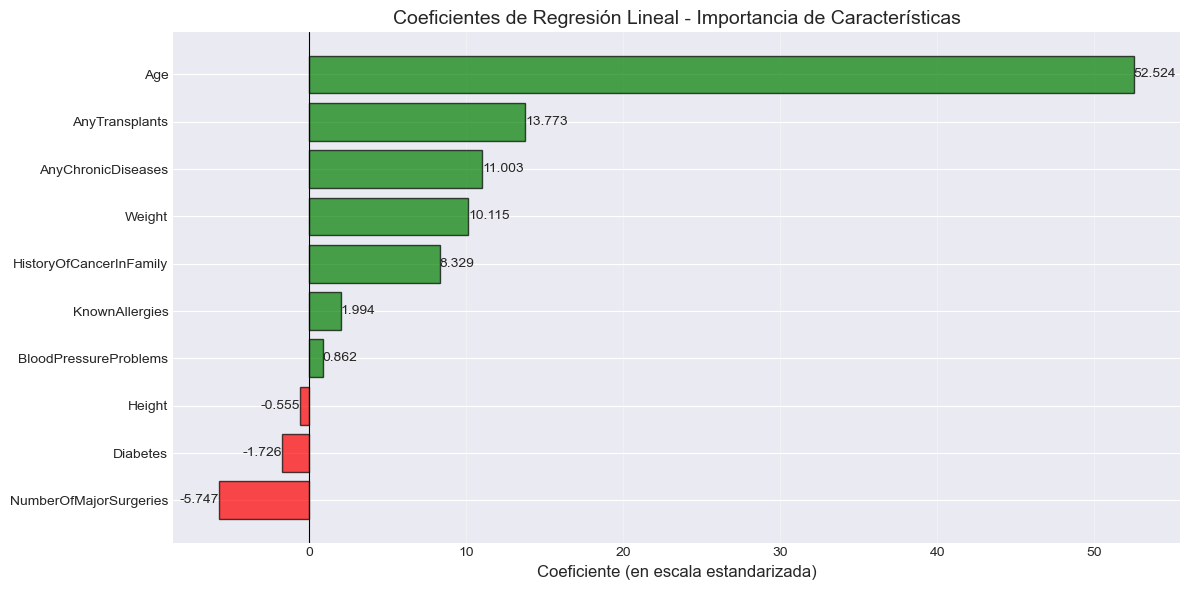

In [271]:
# Visualización de coeficientes
fig, ax = plt.subplots(figsize=(12, 6))

coef_df_sorted = coef_df.sort_values('Coeficiente')
colors = ['red' if c < 0 else 'green' for c in coef_df_sorted['Coeficiente']]

bars = ax.barh(coef_df_sorted['Característica'], coef_df_sorted['Coeficiente'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Coeficiente (en escala estandarizada)', fontsize=12)
ax.set_title('Coeficientes de Regresión Lineal - Importancia de Características', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Añadir valores
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
            ha='left' if width > 0 else 'right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 4.2 Regresión lineal penalizada - Ridge:

In [272]:
print("Buscando mejor alpha para Ridge con GridSearchCV...\n")

param_grid_ridge = {
    'alpha': np.logspace(-10, 10, 30)
}

ridge = Ridge(max_iter=10000)

grid_ridge = GridSearchCV(
    ridge,
    param_grid_ridge,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_ridge.fit(X_train_scaled, y_train)

best_alpha_ridge = grid_ridge.best_params_['alpha']

print("\n✓ Búsqueda Ridge completada")
print(f"  Mejor alpha (Ridge): {best_alpha_ridge}")
print(f"  Mejor RMSE CV (Ridge): {-grid_ridge.best_score_:.4f}")


Buscando mejor alpha para Ridge con GridSearchCV...

Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Búsqueda Ridge completada
  Mejor alpha (Ridge): 2.21221629107045
  Mejor RMSE CV (Ridge): 40.5145


In [273]:
# Entrenar modelo final Ridge con el mejor alpha
ridge_best = Ridge(alpha=best_alpha_ridge, max_iter=10000, random_state=19)
ridge_best.fit(X_train_scaled, y_train)

# Predicciones
y_pred_ridge_train = ridge_best.predict(X_train_scaled)
y_pred_ridge_test = ridge_best.predict(X_test_scaled)

# Métricas
rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
r2_ridge_train = r2_score(y_train, y_pred_ridge_train)
r2_ridge_test = r2_score(y_test, y_pred_ridge_test)
mae_ridge_train = mean_absolute_error(y_train, y_pred_ridge_train)
mae_ridge_test = mean_absolute_error(y_test, y_pred_ridge_test)
ridge_mape_train = mean_absolute_percentage_error(y_train, y_pred_ridge_train)
ridge_mape_test = mean_absolute_percentage_error(y_test, y_pred_ridge_test)

print("="*70)
print(f"REGRESIÓN RIDGE (alpha={best_alpha_ridge})")
print("="*70)

print("\nCoeficientes del modelo:")
coef_df_ridge = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': ridge_best.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

# Definir anchos de columnas dinámicamente
feat_col_width = max(coef_df_ridge['Característica'].str.len().max(), len("Característica")) + 2
coef_col_width = max(len("Coeficiente"), 12)

# Encabezado
header = f"{'Característica':<{feat_col_width}}{'Coeficiente':>{coef_col_width}}    Interpretación"
print("\n" + header)
print("-" * len(header))

# Filas
for _, row in coef_df_ridge.iterrows():
    feat = row['Característica']
    coef = row['Coeficiente']
    interp = '↑ Aumenta precio' if coef > 0 else '↓ Disminuye precio'
    print(f"{feat:<{feat_col_width}}{coef:>{coef_col_width}.6f}    {interp}")

print(f"\nIntercepto: {ridge_best.intercept_:.6f}")

print("\nMétricas de Rendimiento:")
print("\n" + " "*25 + "Train        Test")
print("-" * 50)
print(f"{'RMSE':<20} {rmse_ridge_train:>10.4f}   {rmse_ridge_test:>10.4f}")
print(f"{'MAE':<20} {mae_ridge_train:>10.4f}   {mae_ridge_test:>10.4f}")
print(f"{'R²':<20} {r2_ridge_train:>10.4f}   {r2_ridge_test:>10.4f}")
print(f"{'MAPE (%)':<20} {ridge_mape_train:>10.4f}   {ridge_mape_test:>10.4f}")

REGRESIÓN RIDGE (alpha=2.21221629107045)

Coeficientes del modelo:

Característica            Coeficiente    Interpretación
-------------------------------------------------------
Age                         52.316326    ↑ Aumenta precio
AnyTransplants              13.731632    ↑ Aumenta precio
AnyChronicDiseases          10.984721    ↑ Aumenta precio
Weight                      10.085149    ↑ Aumenta precio
HistoryOfCancerInFamily      8.280848    ↑ Aumenta precio
NumberOfMajorSurgeries      -5.637304    ↓ Disminuye precio
KnownAllergies               1.985197    ↑ Aumenta precio
Diabetes                    -1.699422    ↓ Disminuye precio
BloodPressureProblems        0.884083    ↑ Aumenta precio
Height                      -0.542148    ↓ Disminuye precio

Intercepto: 265.758883

Métricas de Rendimiento:

                         Train        Test
--------------------------------------------------
RMSE                    39.7715      47.6036
MAE                     29.1115      30.7951

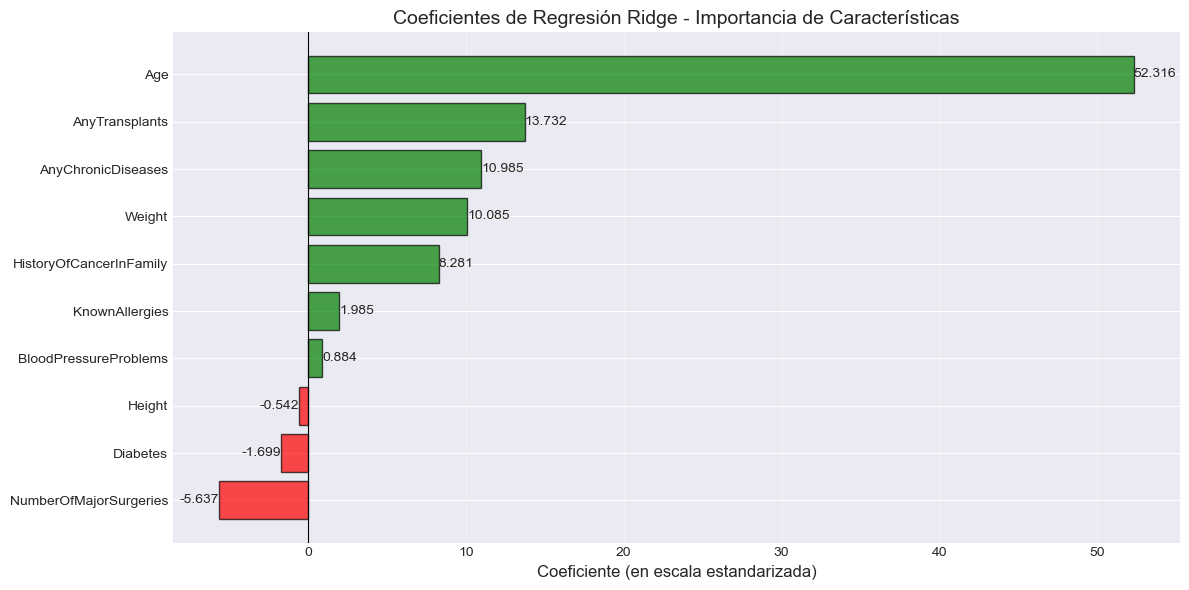

In [274]:
# Visualización de coeficientes
fig, ax = plt.subplots(figsize=(12, 6))

coef_df_sorted = coef_df_ridge.sort_values('Coeficiente')
colors = ['red' if c < 0 else 'green' for c in coef_df_sorted['Coeficiente']]

bars = ax.barh(coef_df_sorted['Característica'], coef_df_sorted['Coeficiente'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Coeficiente (en escala estandarizada)', fontsize=12)
ax.set_title('Coeficientes de Regresión Ridge - Importancia de Características', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Añadir valores
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
            ha='left' if width > 0 else 'right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 4.3 Regresión lineal penalizada - Lasso:

In [275]:
print("\nBuscando mejor alpha para Lasso con GridSearchCV...\n")

param_grid_lasso = {
    'alpha': np.logspace(-3, 1, 50)
}

lasso = Lasso(max_iter=10000, random_state=42)

grid_lasso = GridSearchCV(
    lasso,
    param_grid_lasso,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_lasso.fit(X_train_scaled, y_train)

best_alpha_lasso = grid_lasso.best_params_['alpha']

print("\n✓ Búsqueda Lasso completada")
print(f"  Mejor alpha (Lasso): {best_alpha_lasso}")
print(f"  Mejor RMSE CV (Lasso): {-grid_lasso.best_score_:.4f}")


Buscando mejor alpha para Lasso con GridSearchCV...

Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Búsqueda Lasso completada
  Mejor alpha (Lasso): 0.2811768697974228
  Mejor RMSE CV (Lasso): 40.5045


In [276]:
# Entrenar modelo final Lasso con el mejor alpha
lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=10000, random_state=19)
lasso_best.fit(X_train_scaled, y_train)

# Predicciones
y_pred_lasso_train = lasso_best.predict(X_train_scaled)
y_pred_lasso_test = lasso_best.predict(X_test_scaled)

# Métricas
lasso_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_lasso_train))
lasso_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lasso_test))
lasso_r2_train = r2_score(y_train, y_pred_lasso_train)
lasso_r2_test = r2_score(y_test, y_pred_lasso_test)
lasso_mae_train = mean_absolute_error(y_train, y_pred_lasso_train)
lasso_mae_test = mean_absolute_error(y_test, y_pred_lasso_test)
lasso_mape_train = mean_absolute_percentage_error(y_train, y_pred_lasso_train)
lasso_mape_test = mean_absolute_percentage_error(y_test, y_pred_lasso_test)

print("="*70)
print(f"REGRESIÓN LASSO (alpha={best_alpha_lasso})")
print("="*70)

print("\nCoeficientes del modelo:")
coef_df_lasso = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': lasso_best.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

# Definir anchos de columnas dinámicamente
feat_col_width = max(coef_df_lasso['Característica'].str.len().max(), len("Característica")) + 2
coef_col_width = max(len("Coeficiente"), 12)

# Encabezado
header = f"{'Característica':<{feat_col_width}}{'Coeficiente':>{coef_col_width}}    Interpretación"
print("\n" + header)
print("-" * len(header))

# Filas
for _, row in coef_df_lasso.iterrows():
    feat = row['Característica']
    coef = row['Coeficiente']
    interp = '↑ Aumenta precio' if coef > 0 else '↓ Disminuye precio'
    print(f"{feat:<{feat_col_width}}{coef:>{coef_col_width}.6f}    {interp}")

print(f"\nIntercepto: {lasso_best.intercept_:.6f}")

print("\nMétricas de Rendimiento:")
print("\n" + " "*25 + "Train        Test")
print("-" * 50)
print(f"{'RMSE':<20} {lasso_rmse_train:>10.4f}   {lasso_rmse_test:>10.4f}")
print(f"{'MAE':<20} {lasso_mae_train:>10.4f}   {lasso_mae_test:>10.4f}")
print(f"{'R²':<20} {lasso_r2_train:>10.4f}   {lasso_r2_test:>10.4f}")
print(f"{'MAPE (%)':<20} {lasso_mape_train:>10.4f}   {lasso_mape_test:>10.4f}")

REGRESIÓN LASSO (alpha=0.2811768697974228)

Coeficientes del modelo:

Característica            Coeficiente    Interpretación
-------------------------------------------------------
Age                         51.945100    ↑ Aumenta precio
AnyTransplants              13.496766    ↑ Aumenta precio
AnyChronicDiseases          10.773793    ↑ Aumenta precio
Weight                       9.795592    ↑ Aumenta precio
HistoryOfCancerInFamily      7.951876    ↑ Aumenta precio
NumberOfMajorSurgeries      -5.062592    ↓ Disminuye precio
KnownAllergies               1.720741    ↑ Aumenta precio
Diabetes                    -1.433720    ↓ Disminuye precio
BloodPressureProblems        0.546764    ↑ Aumenta precio
Height                      -0.259159    ↓ Disminuye precio

Intercepto: 265.758883

Métricas de Rendimiento:

                         Train        Test
--------------------------------------------------
RMSE                    39.7839      47.7636
MAE                     29.0947      30.96

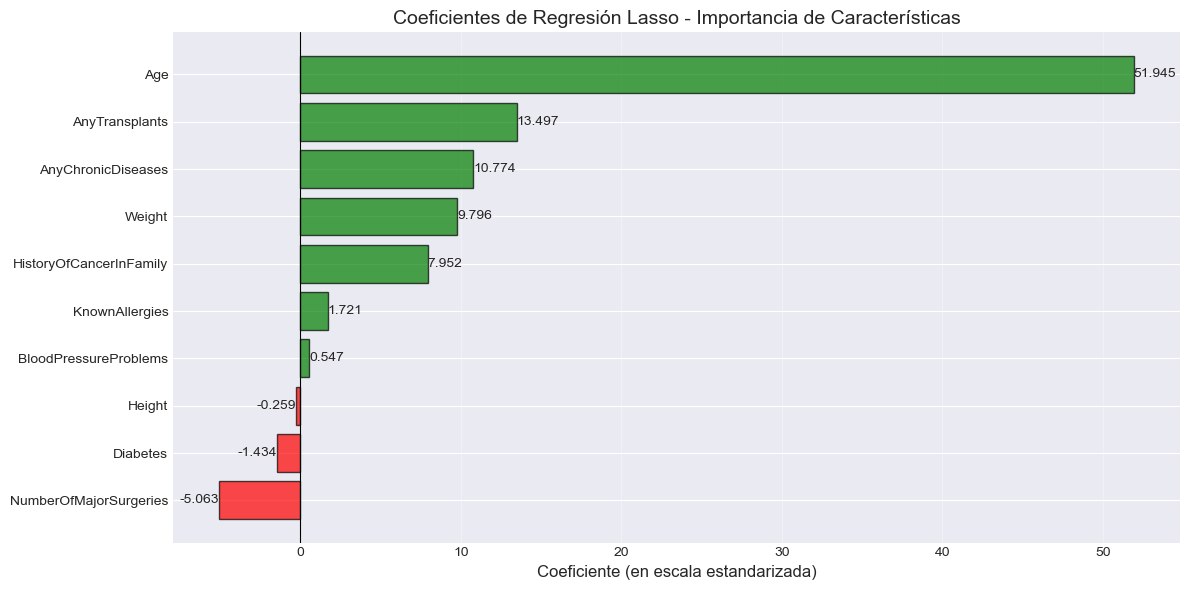

In [277]:
# Visualización de coeficientes
fig, ax = plt.subplots(figsize=(12, 6))

coef_df_sorted = coef_df_lasso.sort_values('Coeficiente')
colors = ['red' if c < 0 else 'green' for c in coef_df_sorted['Coeficiente']]

bars = ax.barh(coef_df_sorted['Característica'], coef_df_sorted['Coeficiente'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Coeficiente (en escala estandarizada)', fontsize=12)
ax.set_title('Coeficientes de Regresión Lasso - Importancia de Características', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Añadir valores
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
            ha='left' if width > 0 else 'right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 4.4 Regresión lineal penalizada - Elastic Net (Combina Ridge y Lasso):

In [278]:
print("\nEntrenando Elastic Net con GridSearchCV refinado...\n")

# Construimos una grilla de alpha alrededor de los mejores de Ridge y Lasso
alpha_min = min(best_alpha_ridge, best_alpha_lasso)
alpha_max = max(best_alpha_ridge, best_alpha_lasso)

# Si por ejemplo alpha_min y alpha_max son iguales o muy pequeños, generamos igualmente una grilla logarítmica razonable
alpha_space = sorted(set(
    list(np.logspace(np.log10(alpha_min/10), np.log10(alpha_max*10), 6))
))

param_grid_elasticnet = {
    'alpha': alpha_space,
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elasticnet = ElasticNet(random_state=19, max_iter=10000)
grid_elasticnet = GridSearchCV(
    elasticnet,
    param_grid_elasticnet,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_elasticnet.fit(X_train_scaled, y_train)

best_alpha_en = grid_elasticnet.best_params_['alpha']
best_l1_ratio_en = grid_elasticnet.best_params_['l1_ratio']

print("\n✓ Búsqueda Elastic Net completada")
print(f"  Mejor alpha (EN):    {best_alpha_en}")
print(f"  Mejor l1_ratio (EN): {best_l1_ratio_en}")
print(f"  Mejor RMSE CV (EN):  {-grid_elasticnet.best_score_:.4f}")


Entrenando Elastic Net con GridSearchCV refinado...

Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Búsqueda Elastic Net completada
  Mejor alpha (EN):    0.02811768697974228
  Mejor l1_ratio (EN): 0.9
  Mejor RMSE CV (EN):  40.5128


In [284]:
# Modelo final Elastic Net
elasticnet_best = ElasticNet(
    alpha=best_alpha_en,
    l1_ratio=best_l1_ratio_en,
    random_state=19,
    max_iter=10000
)
elasticnet_best.fit(X_train_scaled, y_train)

y_pred_en_train = elasticnet_best.predict(X_train_scaled)
y_pred_en_test = elasticnet_best.predict(X_test_scaled)

# Métricas
en_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_en_train))
en_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_en_test))
en_mae_train = mean_absolute_error(y_train, y_pred_en_train)
en_mae_test = mean_absolute_error(y_test, y_pred_en_test)
en_r2_train = r2_score(y_train, y_pred_en_train)
en_r2_test = r2_score(y_test, y_pred_en_test)
en_mape_train = mean_absolute_percentage_error(y_train, y_pred_en_train)
en_mape_test = mean_absolute_percentage_error(y_test, y_pred_en_test)

print("="*70)
print("ELASTIC NET REGRESSION")
print("="*70)
print(f"\nHiperparámetros: alpha={grid_elasticnet.best_params_['alpha']}, l1_ratio={grid_elasticnet.best_params_['l1_ratio']}")

print("\nCoeficientes del modelo:")
coef_df_en = pd.DataFrame({
    'Característica': X.columns,
    'Coeficiente': elasticnet_best.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

# Definir anchos de columnas dinámicamente
feat_col_width = max(coef_df_en['Característica'].str.len().max(), len("Característica")) + 2
coef_col_width = max(len("Coeficiente"), 12)

# Encabezado
header = f"{'Característica':<{feat_col_width}}{'Coeficiente':>{coef_col_width}}    Status"
print("\n" + header)
print("-" * len(header))

# Filas
for _, row in coef_df_en.iterrows():
    feat = row['Característica']
    coef = row['Coeficiente']
    status = "Eliminada" if abs(coef) < 0.0001 else "Activa"
    print(f"{feat:<{feat_col_width}}{coef:>{coef_col_width}.6f}    {status}")

print("\nMétricas de Rendimiento:")
print("\n" + " "*25 + "Train        Test")
print("-" * 50)
print(f"{'RMSE':<20} {en_rmse_train:>10.4f}   {en_rmse_test:>10.4f}")
print(f"{'MAE':<20} {en_mae_train:>10.4f}   {en_mae_test:>10.4f}")
print(f"{'R²':<20} {en_r2_train:>10.4f}   {en_r2_test:>10.4f}")
print(f"{'MAPE (%)':<20} {en_mape_train:>10.4f}   {en_mape_test:>10.4f}")

ELASTIC NET REGRESSION

Hiperparámetros: alpha=0.02811768697974228, l1_ratio=0.9

Coeficientes del modelo:

Característica            Coeficiente    Status
-----------------------------------------------
Age                         52.264294    Activa
AnyTransplants              13.706805    Activa
AnyChronicDiseases          10.964087    Activa
Weight                      10.056407    Activa
HistoryOfCancerInFamily      8.246919    Activa
NumberOfMajorSurgeries      -5.575912    Activa
KnownAllergies               1.960718    Activa
Diabetes                    -1.673187    Activa
BloodPressureProblems        0.855828    Activa
Height                      -0.515527    Activa

Métricas de Rendimiento:

                         Train        Test
--------------------------------------------------
RMSE                    39.7719      47.6176
MAE                     29.1098      30.8126
R²                       0.6557       0.5588
MAPE (%)                 0.1147       0.1078


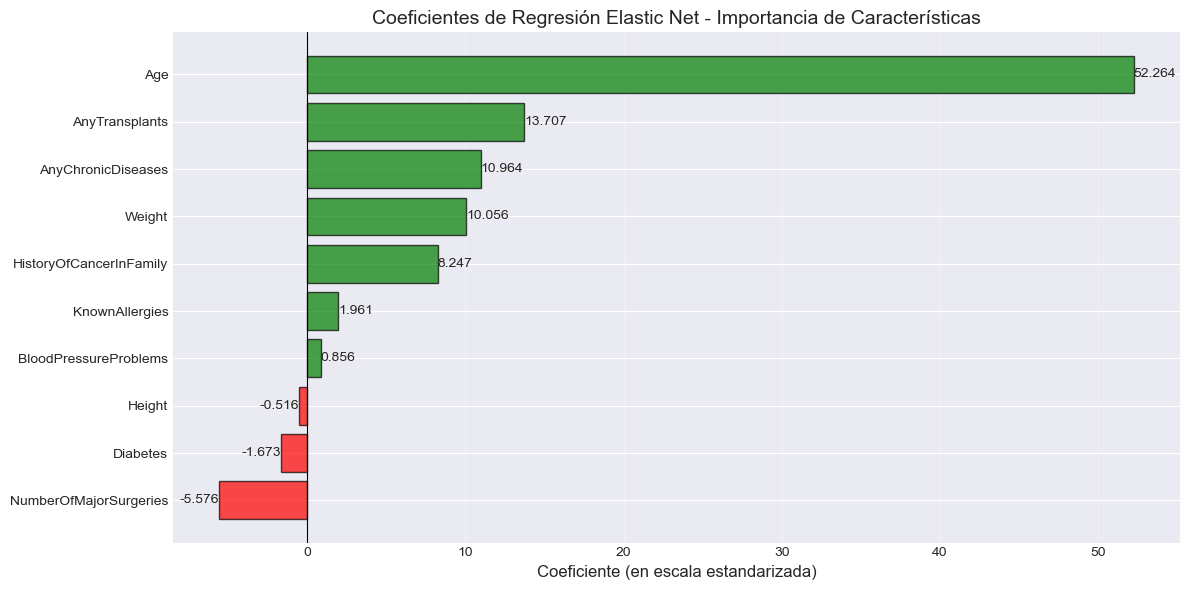

In [280]:
# Visualización de coeficientes
fig, ax = plt.subplots(figsize=(12, 6))

coef_df_sorted = coef_df_en.sort_values('Coeficiente')
colors = ['red' if c < 0 else 'green' for c in coef_df_sorted['Coeficiente']]

bars = ax.barh(coef_df_sorted['Característica'], coef_df_sorted['Coeficiente'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Coeficiente (en escala estandarizada)', fontsize=12)
ax.set_title('Coeficientes de Regresión Elastic Net - Importancia de Características', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Añadir valores
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
            ha='left' if width > 0 else 'right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 4.5 Comparación de modelos de regresión:

In [287]:
comparacion_modelos = pd.DataFrame({
    'Modelo':      ['OLS',        'Ridge',            'Lasso',             'Elastic Net'],
    'RMSE_train':  [lr_rmse_train, rmse_ridge_train,   lasso_rmse_train,    en_rmse_train],
    'RMSE_test':   [lr_rmse_test,  rmse_ridge_test,    lasso_rmse_test,     en_rmse_test],
    'MAE_train':   [lr_mae_train,  mae_ridge_train,    lasso_mae_train,     en_mae_train],
    'MAE_test':    [lr_mae_test,   mae_ridge_test,     lasso_mae_test,      en_mae_test],
    'R2_train':    [lr_r2_train,   r2_ridge_train,     lasso_r2_train,      en_r2_train],
    'R2_test':     [lr_r2_test,    r2_ridge_test,      lasso_r2_test,       en_r2_test],
    'MAPE_train_%':[lr_mape_train*100, ridge_mape_train*100, lasso_mape_train*100, en_mape_train*100],
    'MAPE_test_%': [lr_mape_test*100,  ridge_mape_test*100,  lasso_mape_test*100,  en_mape_test*100]
})

comparacion_modelos = comparacion_modelos.set_index('Modelo')

print("\n" + "="*70)
print("COMPARACIÓN DE MÉTRICAS ENTRE MODELOS")
print("="*70 + "\n")

print(comparacion_modelos.round(4))

# Identificar el mejor modelo
best_model_name = comparacion_modelos['RMSE_test'].idxmin()
print(f"\n🏆 Mejor modelo basado en RMSE de prueba: {best_model_name}")


COMPARACIÓN DE MÉTRICAS ENTRE MODELOS

             RMSE_train  RMSE_test  MAE_train  MAE_test  R2_train  R2_test  \
Modelo                                                                       
OLS             39.7710    47.6016    29.1053   30.7691    0.6557   0.5591   
Ridge           39.7715    47.6036    29.1115   30.7951    0.6557   0.5591   
Lasso           39.7839    47.7636    29.0947   30.9673    0.6555   0.5561   
Elastic Net     39.7719    47.6176    29.1098   30.8126    0.6557   0.5588   

             MAPE_train_%  MAPE_test_%  
Modelo                                  
OLS               11.4573      10.7533  
Ridge             11.4659      10.7711  
Lasso             11.4596      10.8360  
Elastic Net       11.4658      10.7784  

🏆 Mejor modelo basado en RMSE de prueba: OLS


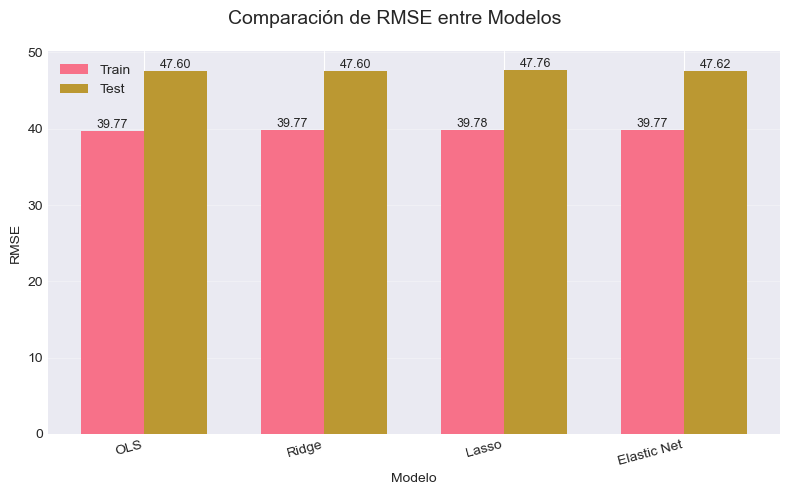

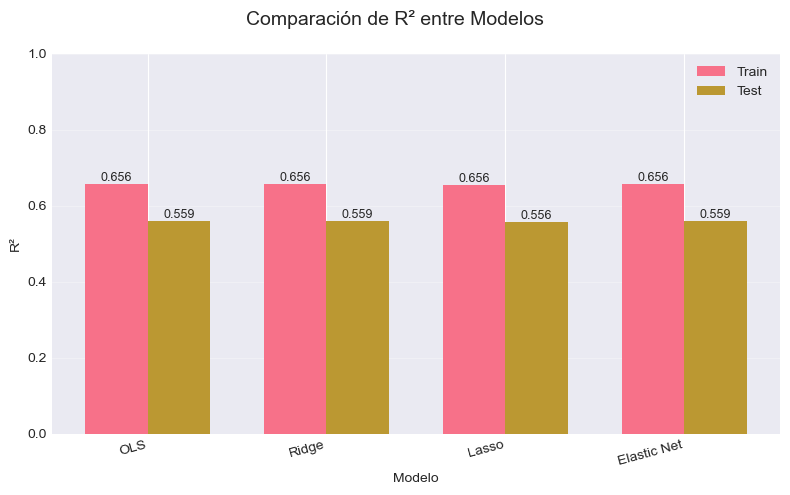

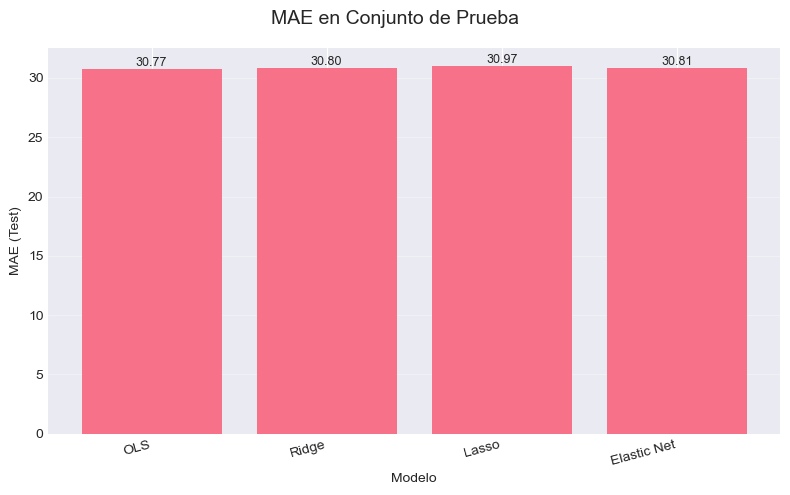

In [288]:
models = comparacion_modelos.index.tolist()
x_pos = np.arange(len(models))
width = 0.35  # ancho de barra para train/test

# ==========================
# 1) RMSE (Train vs Test)
# ==========================
fig_rmse, ax1 = plt.subplots(figsize=(8, 5))
fig_rmse.suptitle('Comparación de RMSE entre Modelos', fontsize=14)

bars1 = ax1.bar(x_pos - width/2, comparacion_modelos['RMSE_train'], width, label='Train')
bars2 = ax1.bar(x_pos + width/2, comparacion_modelos['RMSE_test'],  width, label='Test')

ax1.set_xlabel('Modelo')
ax1.set_ylabel('RMSE')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Etiquetas numéricas en las barras
for bars, ax in [(bars1, ax1), (bars2, ax1)]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# ==========================
# 2) R² (Train vs Test)
# ==========================
fig_r2, ax2 = plt.subplots(figsize=(8, 5))
fig_r2.suptitle('Comparación de R² entre Modelos', fontsize=14)

bars3 = ax2.bar(x_pos - width/2, comparacion_modelos['R2_train'], width, label='Train')
bars4 = ax2.bar(x_pos + width/2, comparacion_modelos['R2_test'],  width, label='Test')

ax2.set_xlabel('Modelo')
ax2.set_ylabel('R²')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1)  # R² entre 0 y 1

for bars, ax in [(bars3, ax2), (bars4, ax2)]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# ==========================
# 3) MAE (solo Test)
# ==========================
fig_mae, ax3 = plt.subplots(figsize=(8, 5))
fig_mae.suptitle('MAE en Conjunto de Prueba', fontsize=14)

bars5 = ax3.bar(x_pos, comparacion_modelos['MAE_test'])

ax3.set_xlabel('Modelo')
ax3.set_ylabel('MAE (Test)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models, rotation=15, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

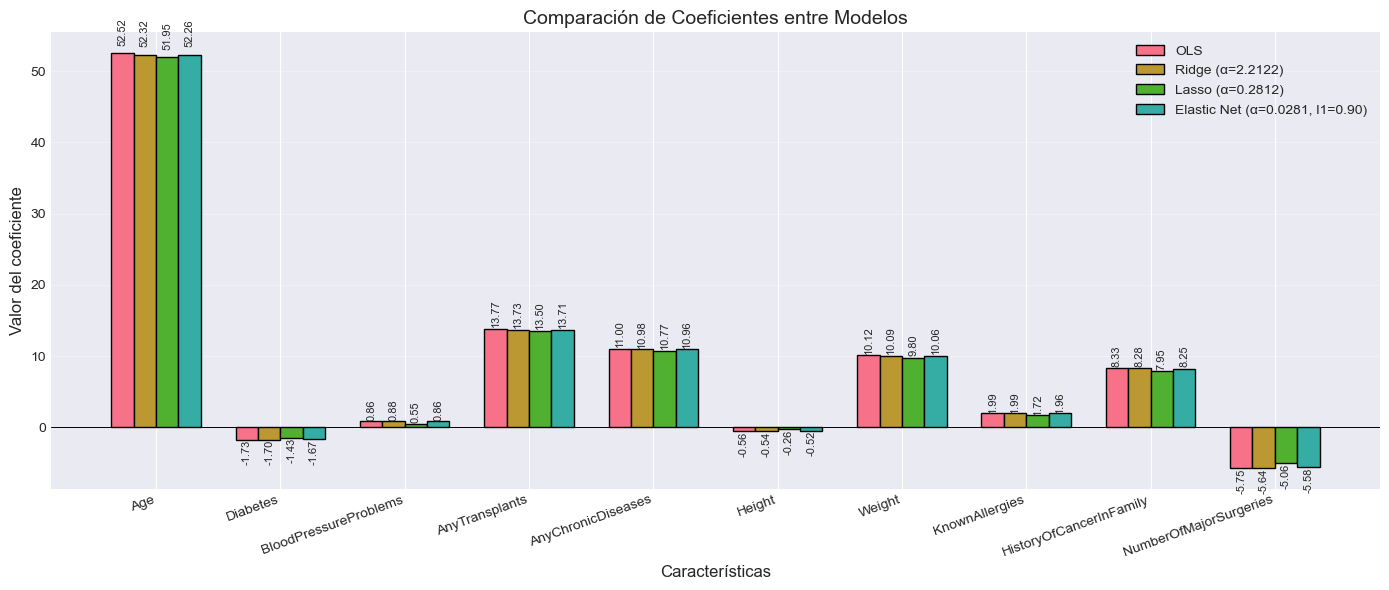

In [289]:
# Visualización de coeficientes para OLS, Ridge, Lasso y Elastic Net
fig, ax = plt.subplots(figsize=(14, 6))

features = X.columns.tolist()
x_pos = np.arange(len(features))

# 4 modelos → barras más delgadas
width = 0.18

# Coeficientes de cada modelo
coef_ols   = lr_model.coef_
coef_ridge = ridge_best.coef_
coef_lasso = lasso_best.coef_
coef_en    = elasticnet_best.coef_

# Barras desplazadas para que no se encimen
bars1 = ax.bar(x_pos - 1.5*width, coef_ols,   width, label='OLS', edgecolor='black')
bars2 = ax.bar(x_pos - 0.5*width, coef_ridge, width, label=f'Ridge (α={best_alpha_ridge:.4f})', edgecolor='black')
bars3 = ax.bar(x_pos + 0.5*width, coef_lasso, width, label=f'Lasso (α={best_alpha_lasso:.4f})', edgecolor='black')
bars4 = ax.bar(x_pos + 1.5*width, coef_en,    width, label=f'Elastic Net (α={best_alpha_en:.4f}, l1={best_l1_ratio_en:.2f})', edgecolor='black')

ax.set_xlabel('Características', fontsize=12)
ax.set_ylabel('Valor del coeficiente', fontsize=12)
ax.set_title('Comparación de Coeficientes entre Modelos', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(features, rotation=20, ha='right')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.7)

# Función auxiliar para poner etiquetas numéricas
def add_value_labels(bars, axis):
    for bar in bars:
        height = bar.get_height()
        if np.abs(height) > 1e-3:  # no etiquetar coeficientes ~0
            axis.text(
                bar.get_x() + bar.get_width()/2.,
                height + (0.02 * np.sign(height) * max(1, np.abs(height))),  # pequeño offset
                f'{height:.2f}',
                ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=8,
                rotation=90
            )

# Agregar valores (si se ve muy cargado, puedes comentar esta parte)
for bars in [bars1, bars2, bars3, bars4]:
    add_value_labels(bars, ax)

plt.tight_layout()
plt.show()

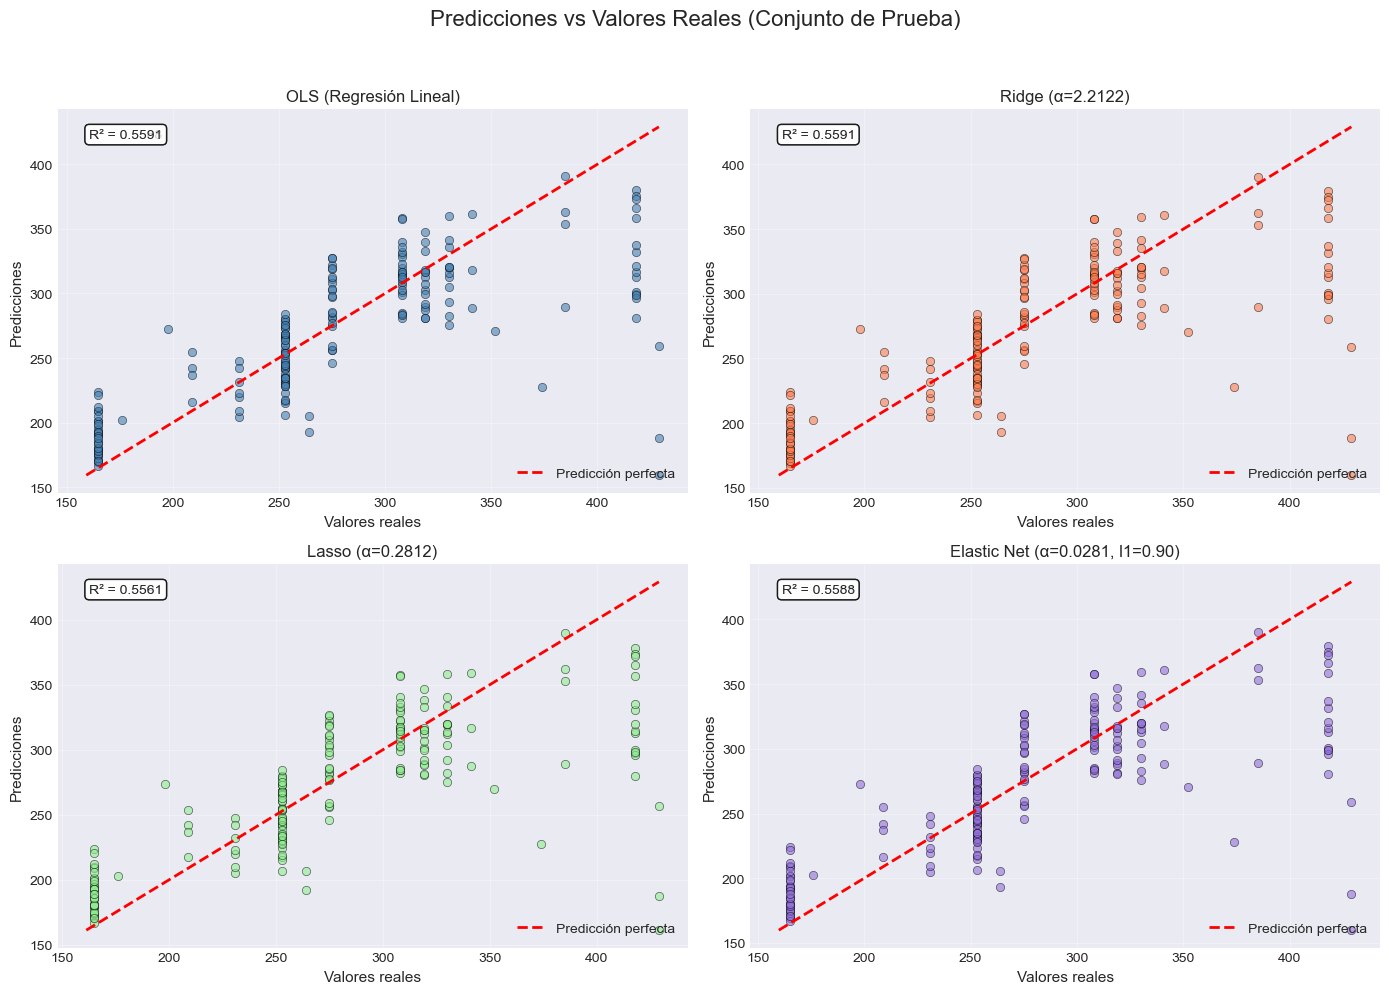

In [292]:
# Gráfico de predicciones vs valores reales para TODOS los modelos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Predicciones vs Valores Reales (Conjunto de Prueba)', fontsize=16, y=0.99)

axes = axes.ravel()  # para iterar fácil sobre los 4 subplots

models_pred = [
    ('OLS (Regresión Lineal)',          y_pred_lr_test,    'steelblue'),
    (f'Ridge (α={best_alpha_ridge:.4f})',   y_pred_ridge_test, 'coral'),
    (f'Lasso (α={best_alpha_lasso:.4f})',   y_pred_lasso_test, 'lightgreen'),
    (f'Elastic Net (α={best_alpha_en:.4f}, l1={best_l1_ratio_en:.2f})', y_pred_en_test, 'mediumpurple')
]

for ax, (name, predictions, color) in zip(axes, models_pred):
    ax.scatter(y_test, predictions, alpha=0.6, color=color, edgecolors='black', linewidth=0.5)
    
    # Línea perfecta de predicción
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')
    
    ax.set_xlabel('Valores reales', fontsize=11)
    ax.set_ylabel('Predicciones', fontsize=11)
    ax.set_title(name, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # R² en el gráfico
    r2 = r2_score(y_test, predictions)
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.96])  # deja espacio al título general
plt.show()

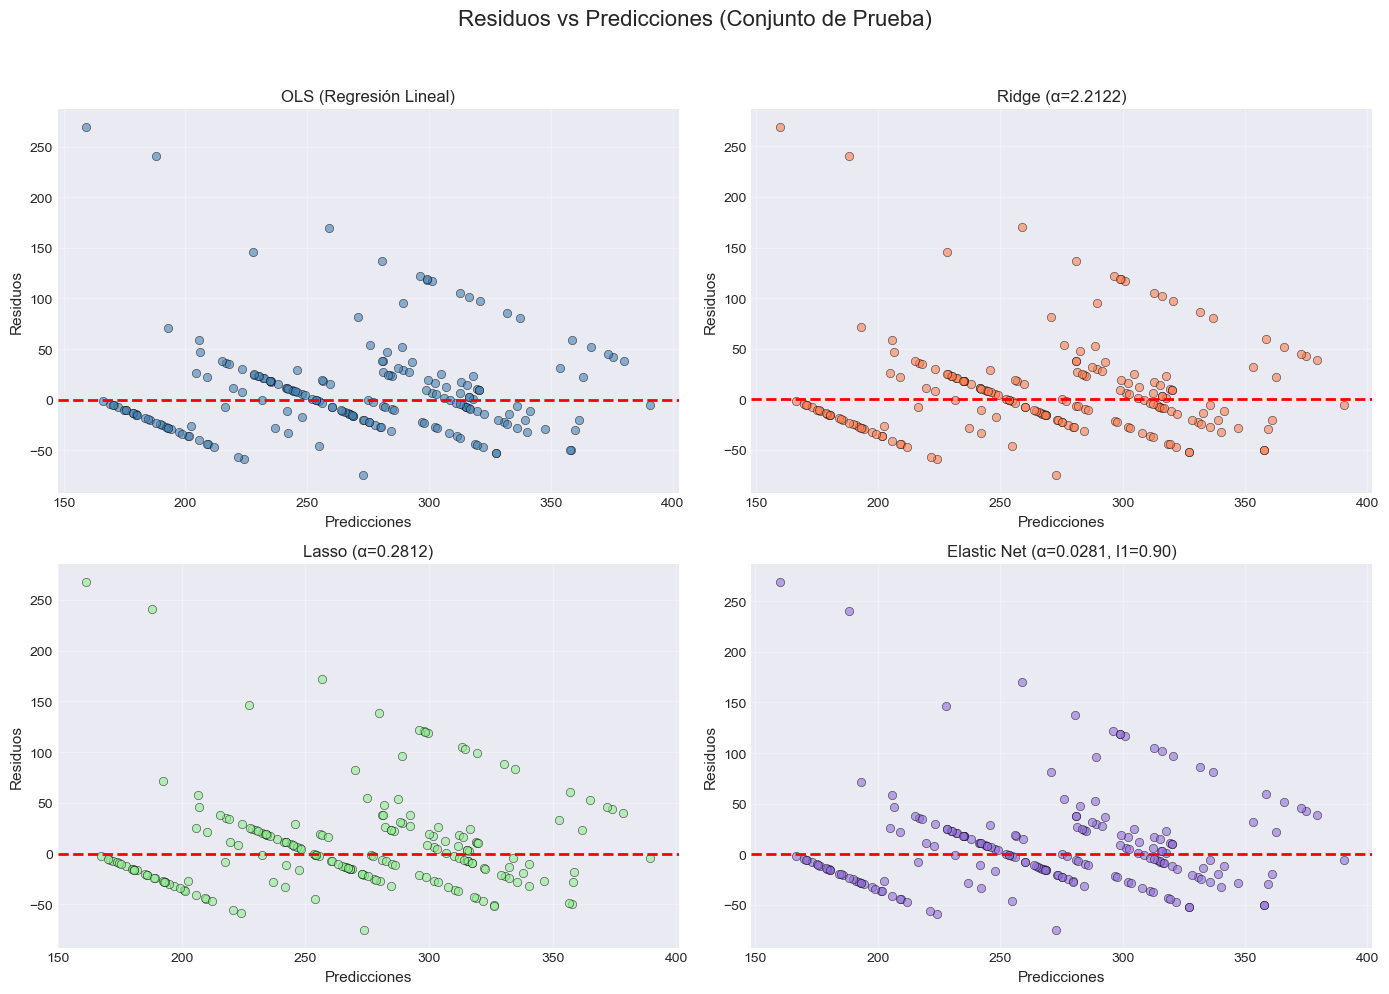

In [293]:
# --- Residuos vs Predicciones ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Residuos vs Predicciones (Conjunto de Prueba)', fontsize=16, y=0.99)

axes = axes.ravel()

models_resid = [
    ('OLS (Regresión Lineal)',              y_pred_lr_test,    'steelblue'),
    (f'Ridge (α={best_alpha_ridge:.4f})',   y_pred_ridge_test, 'coral'),
    (f'Lasso (α={best_alpha_lasso:.4f})',   y_pred_lasso_test, 'lightgreen'),
    (f'Elastic Net (α={best_alpha_en:.4f}, l1={best_l1_ratio_en:.2f})', y_pred_en_test, 'mediumpurple')
]

for ax, (name, predictions, color) in zip(axes, models_resid):
    residuals = y_test - predictions
    
    ax.scatter(predictions, residuals, alpha=0.6,
               color=color, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicciones', fontsize=11)
    ax.set_ylabel('Residuos', fontsize=11)
    ax.set_title(name, fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

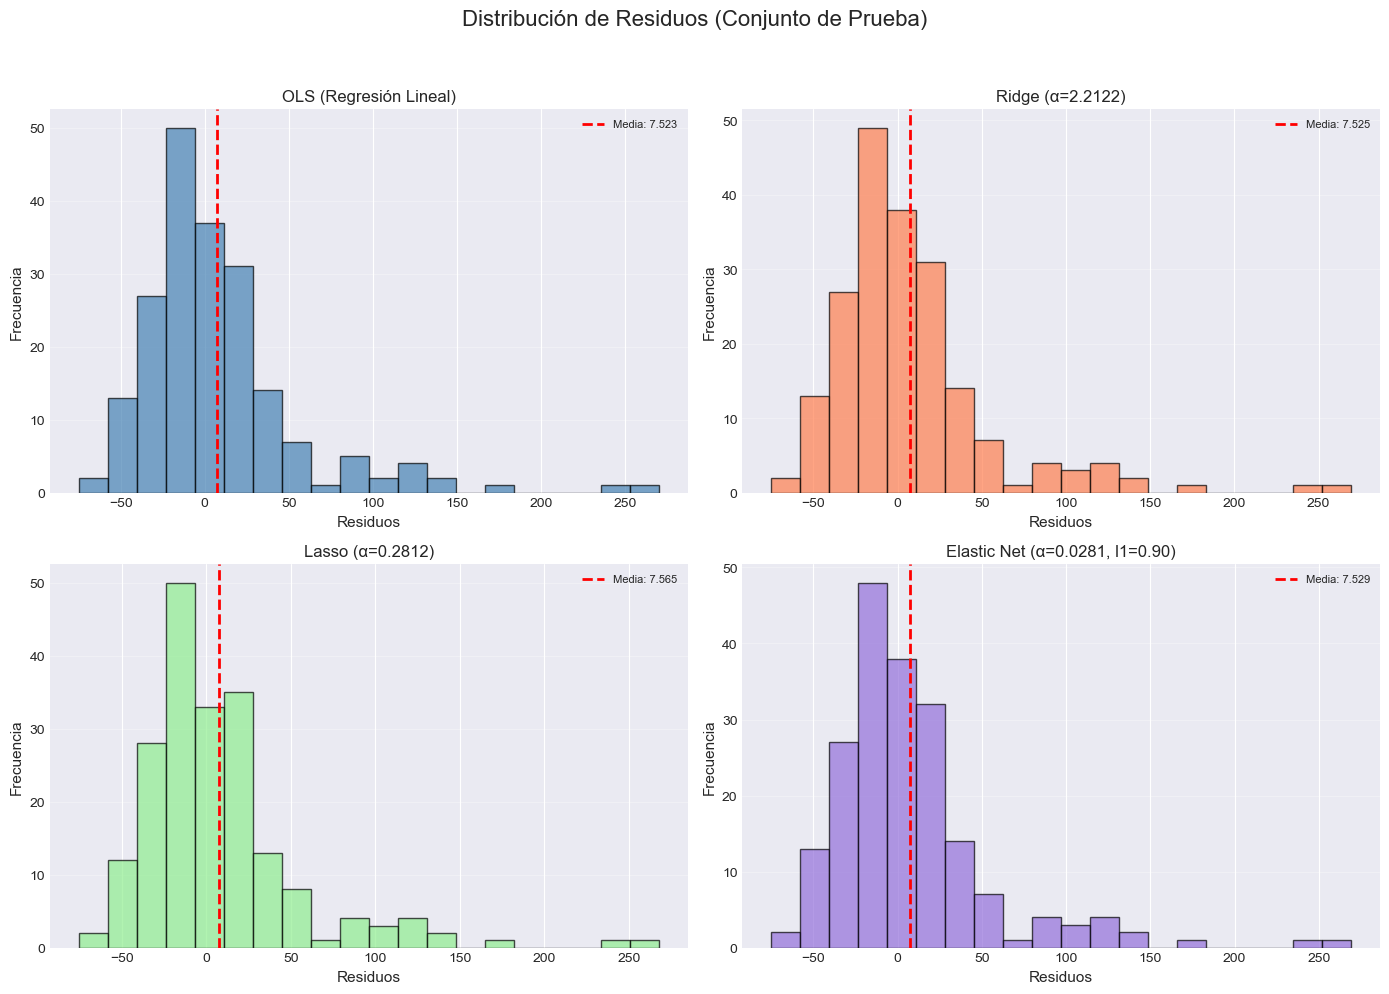

In [294]:
# --- Histogramas de Residuos ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribución de Residuos (Conjunto de Prueba)', fontsize=16, y=0.99)

axes = axes.ravel()

for ax, (name, predictions, color) in zip(axes, models_resid):
    residuals = y_test - predictions
    
    ax.hist(residuals, bins=20, edgecolor='black', alpha=0.7, color=color)
    ax.set_xlabel('Residuos', fontsize=11)
    ax.set_ylabel('Frecuencia', fontsize=11)
    ax.set_title(name, fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Línea de la media de residuos
    mean_resid = residuals.mean()
    ax.axvline(mean_resid, color='red', linestyle='--', linewidth=2,
               label=f'Media: {mean_resid:.3f}')
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 5. Árbol de decisión:

### 6. Bosque:

### 7. Modelado con CatBoost - Regresión de Precios de Seguros

In [255]:
# Entrenar modelo CatBoost
print("\n" + "="*70)
print("ENTRENAMIENTO DEL MODELO CATBOOST")
print("="*70)

start_time = time.time()

# Crear y entrenar modelo con parámetros optimizados
catboost_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_state=42,
    verbose=False,  # Silenciar output detallado
    use_best_model=True,
    early_stopping_rounds=20
)

catboost_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

training_time = time.time() - start_time

print(f"\n✓ Modelo entrenado exitosamente en {training_time:.2f} segundos")
print(f"\nParámetros principales del modelo:")
print(f"  • Iteraciones: {catboost_model.get_param('iterations')}")
print(f"  • Tasa de aprendizaje: {catboost_model.get_param('learning_rate')}")
print(f"  • Profundidad de árboles: {catboost_model.get_param('depth')}")
print(f"  • Número de árboles entrenados: {catboost_model.tree_count_}")



ENTRENAMIENTO DEL MODELO CATBOOST

✓ Modelo entrenado exitosamente en 0.67 segundos

Parámetros principales del modelo:
  • Iteraciones: 200
  • Tasa de aprendizaje: 0.1
  • Profundidad de árboles: 6
  • Número de árboles entrenados: 146


In [256]:
# Evaluación del modelo
print("\n" + "="*70)
print("EVALUACIÓN DEL MODELO CATBOOST")
print("="*70)

# Predicciones
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)

# Calcular métricas
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Mostrar métricas en formato tabular
print("\nMétricas de Desempeño:")
print("-" * 70)
print(f"{'Métrica':<20} {'Entrenamiento':<20} {'Prueba':<20}")
print("-" * 70)
print(f"{'RMSE (USD)':<20} ${train_rmse:>17.2f}  ${test_rmse:>17.2f}")
print(f"{'MAE (USD)':<20} ${train_mae:>17.2f}  ${test_mae:>17.2f}")
print(f"{'MAPE (%)':<20} {train_mape:>18.2f}%  {test_mape:>18.2f}%")
print(f"{'R² Score':<20} {train_r2:>18.4f}  {test_r2:>18.4f}")
print("-" * 70)

# Análisis de overfitting
print(f"\nAnálisis de Overfitting:")
print(f"  • Diferencia RMSE: ${test_rmse - train_rmse:.2f}")
print(f"  • Diferencia R²: {test_r2 - train_r2:.4f}")

if test_rmse - train_rmse > 500:
    print(f"  ⚠ Posible ligero overfitting detectado")
else:
    print(f"  ✓ Modelo generaliza bien a datos no vistos")

# Resumen interpretativo
print(f"\nInterpretación del Desempeño:")
print(f"  • El modelo explica el {test_r2*100:.2f}% de la varianza en los precios de seguros")
print(f"  • En promedio, el modelo se equivoca en ±${test_mae:.2f} por predicción")
print(f"  • Error relativo promedio del {test_mape:.2f}% respecto al valor real")



EVALUACIÓN DEL MODELO CATBOOST

Métricas de Desempeño:
----------------------------------------------------------------------
Métrica              Entrenamiento        Prueba              
----------------------------------------------------------------------
RMSE (USD)           $            18.92  $            42.82
MAE (USD)            $            11.03  $            20.33
MAPE (%)                           0.04%                0.07%
R² Score                         0.9221              0.6432
----------------------------------------------------------------------

Análisis de Overfitting:
  • Diferencia RMSE: $23.90
  • Diferencia R²: -0.2789
  ✓ Modelo generaliza bien a datos no vistos

Interpretación del Desempeño:
  • El modelo explica el 64.32% de la varianza en los precios de seguros
  • En promedio, el modelo se equivoca en ±$20.33 por predicción
  • Error relativo promedio del 0.07% respecto al valor real



IMPORTANCIA DE CARACTERÍSTICAS

Importancia relativa de cada variable:
----------------------------------------------------------------------
Age                       ████████████████████████████░░░░░░░░░░░░░░░░░░░░░░  56.64%
Weight                    ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░  13.59%
AnyTransplants            ████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   9.31%
NumberOfMajorSurgeries    ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   5.30%
AnyChronicDiseases        ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   4.90%
HistoryOfCancerInFamily   █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   3.90%
Height                    █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   3.39%
BloodPressureProblems     ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   1.79%
KnownAllergies            ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0.73%
Diabetes                  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   0.44%


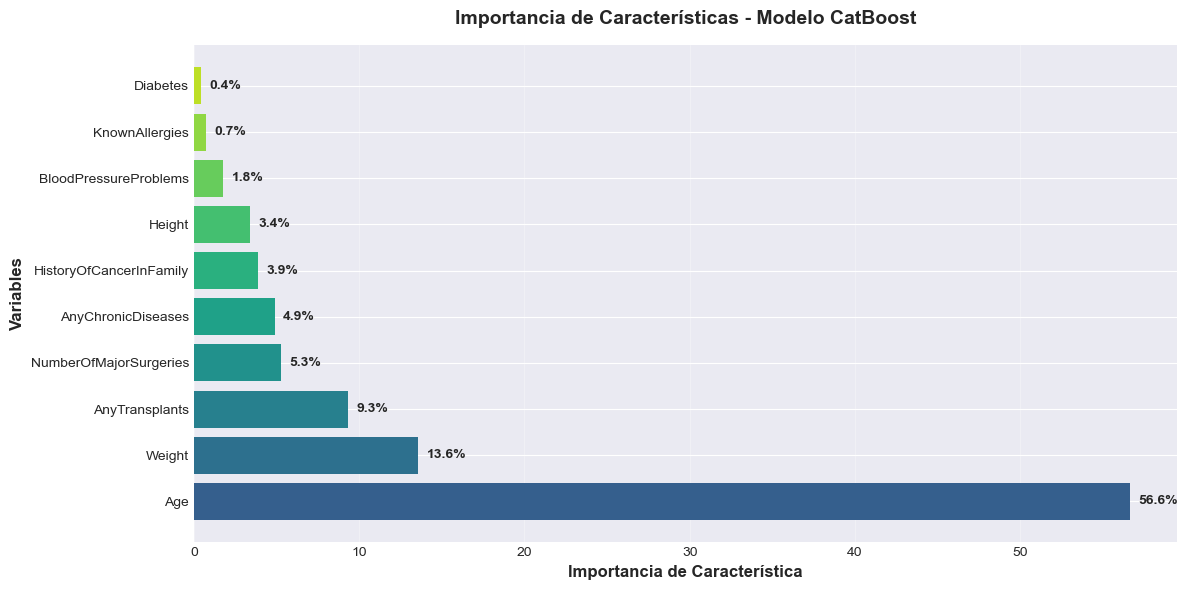


Top 3 características más importantes:
  1. Age: 56.64%
  2. Weight: 13.59%
  3. AnyTransplants: 9.31%


In [257]:
# Análisis de importancia de características
print("\n" + "="*70)
print("IMPORTANCIA DE CARACTERÍSTICAS")
print("="*70)

# Obtener importancia de características
feature_importance = catboost_model.get_feature_importance()
feature_names = X.columns.tolist()

# Crear DataFrame con importancia
df_importance = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': feature_importance
}).sort_values('Importancia', ascending=False)

print("\nImportancia relativa de cada variable:")
print("-" * 70)
for idx, row in df_importance.iterrows():
    pct = (row['Importancia'] / df_importance['Importancia'].sum()) * 100
    bar_length = int(pct / 2)
    bar = "█" * bar_length + "░" * (50 - bar_length)
    print(f"{row['Variable']:<25} {bar} {pct:>6.2f}%")

# Visualización de importancia de características
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_importance)))
barras = ax.barh(df_importance['Variable'], df_importance['Importancia'], color=colors)
ax.set_xlabel('Importancia de Característica', fontsize=12, fontweight='bold')
ax.set_ylabel('Variables', fontsize=12, fontweight='bold')
ax.set_title('Importancia de Características - Modelo CatBoost', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for i, (barra, valor) in enumerate(zip(barras, df_importance['Importancia'])):
    pct = (valor / df_importance['Importancia'].sum()) * 100
    ax.text(valor + 0.5, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTop 3 características más importantes:")
for idx, (i, row) in enumerate(df_importance.head(3).iterrows(), 1):
    pct = (row['Importancia'] / df_importance['Importancia'].sum()) * 100
    print(f"  {idx}. {row['Variable']}: {pct:.2f}%")



ANÁLISIS DE RESIDUOS Y PREDICCIONES


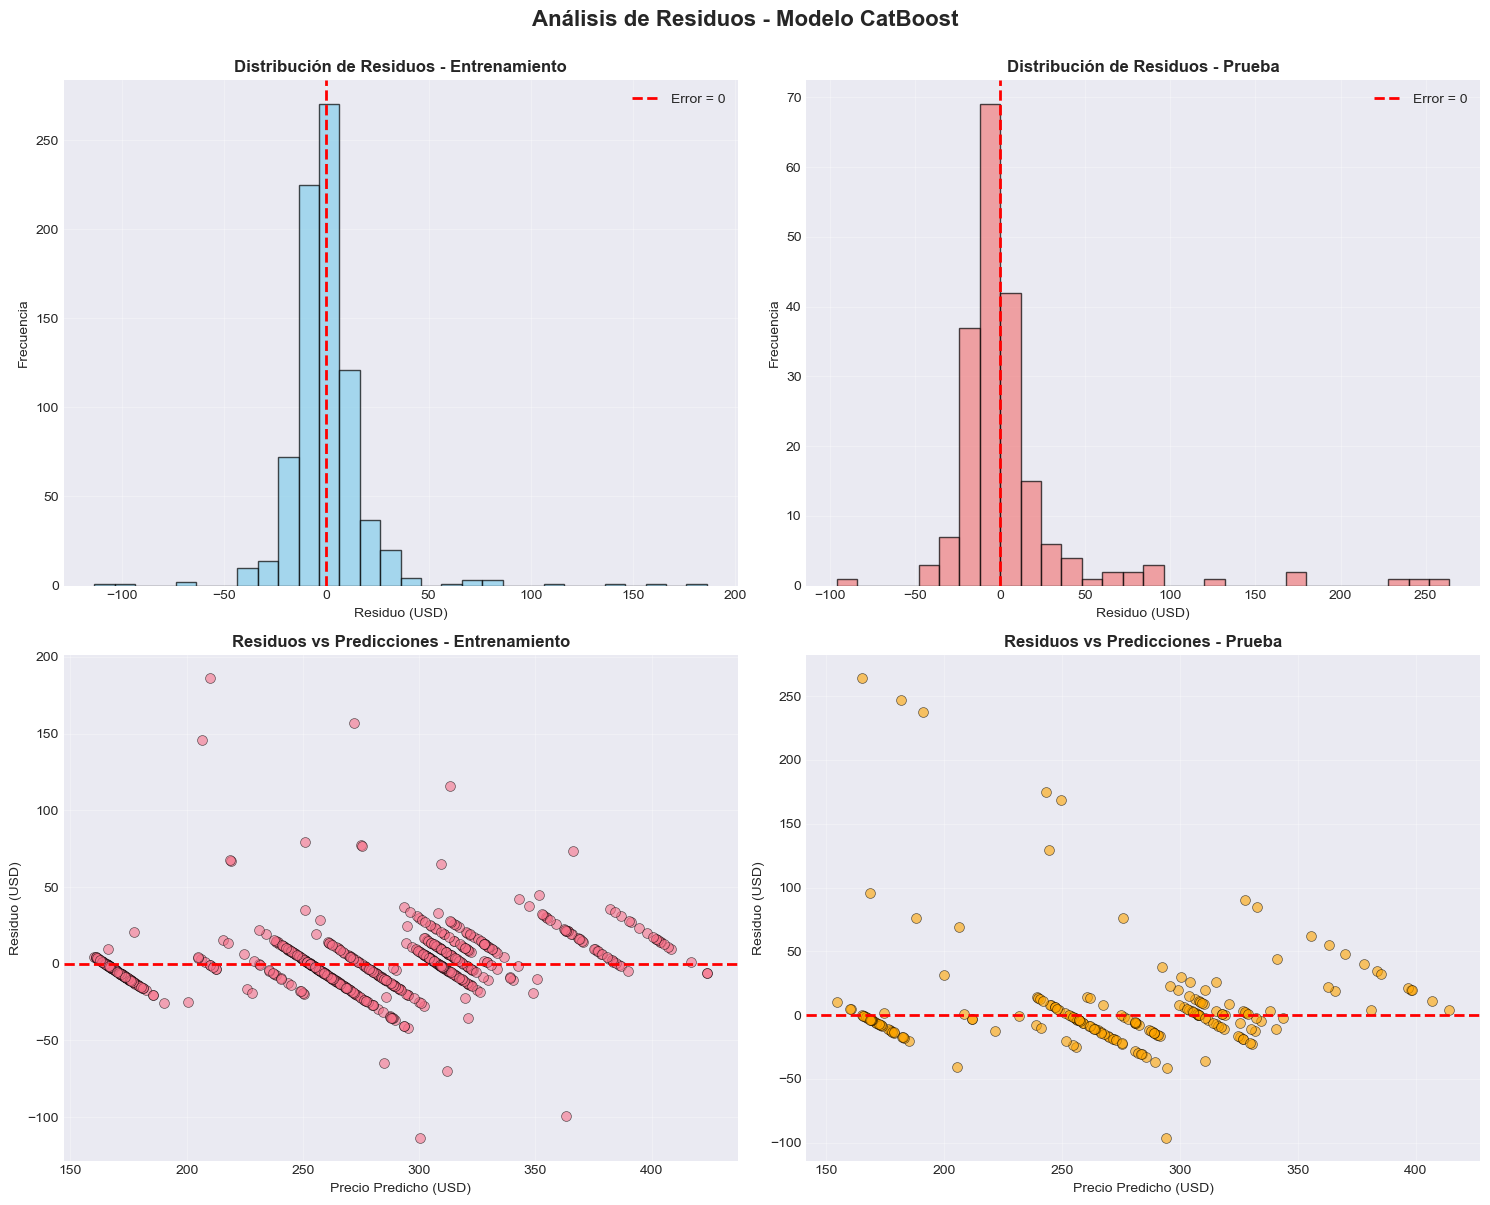


Estadísticas de Residuos:
----------------------------------------------------------------------
Métrica                        Entrenamiento        Prueba              
----------------------------------------------------------------------
Media                          $              0.09  $              6.26
Desv. Estándar                 $             18.93  $             42.47
Mínimo                         $           -113.38  $            -96.06
Máximo                         $            186.09  $            264.01
----------------------------------------------------------------------


In [258]:
# Análisis de residuos
print("\n" + "="*70)
print("ANÁLISIS DE RESIDUOS Y PREDICCIONES")
print("="*70)

# Calcular residuos
residuos_train = y_train - y_train_pred
residuos_test = y_test - y_test_pred

# Crear visualización de residuos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Residuos - Modelo CatBoost', fontsize=16, fontweight='bold', y=1.00)

# 1. Distribución de residuos (Entrenamiento)
axes[0, 0].hist(residuos_train, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[0, 0].set_title('Distribución de Residuos - Entrenamiento', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Residuo (USD)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de residuos (Prueba)
axes[0, 1].hist(residuos_test, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[0, 1].set_title('Distribución de Residuos - Prueba', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residuo (USD)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuos vs Valores Predichos (Entrenamiento)
axes[1, 0].scatter(y_train_pred, residuos_train, alpha=0.6, edgecolors='black', linewidth=0.5, s=50)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuos vs Predicciones - Entrenamiento', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Precio Predicho (USD)')
axes[1, 0].set_ylabel('Residuo (USD)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuos vs Valores Predichos (Prueba)
axes[1, 1].scatter(y_test_pred, residuos_test, alpha=0.6, edgecolors='black', linewidth=0.5, s=50, color='orange')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residuos vs Predicciones - Prueba', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Precio Predicho (USD)')
axes[1, 1].set_ylabel('Residuo (USD)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\nEstadísticas de Residuos:")
print("-" * 70)
print(f"{'Métrica':<30} {'Entrenamiento':<20} {'Prueba':<20}")
print("-" * 70)
print(f"{'Media':<30} ${residuos_train.mean():>18.2f}  ${residuos_test.mean():>18.2f}")
print(f"{'Desv. Estándar':<30} ${residuos_train.std():>18.2f}  ${residuos_test.std():>18.2f}")
print(f"{'Mínimo':<30} ${residuos_train.min():>18.2f}  ${residuos_test.min():>18.2f}")
print(f"{'Máximo':<30} ${residuos_train.max():>18.2f}  ${residuos_test.max():>18.2f}")
print("-" * 70)


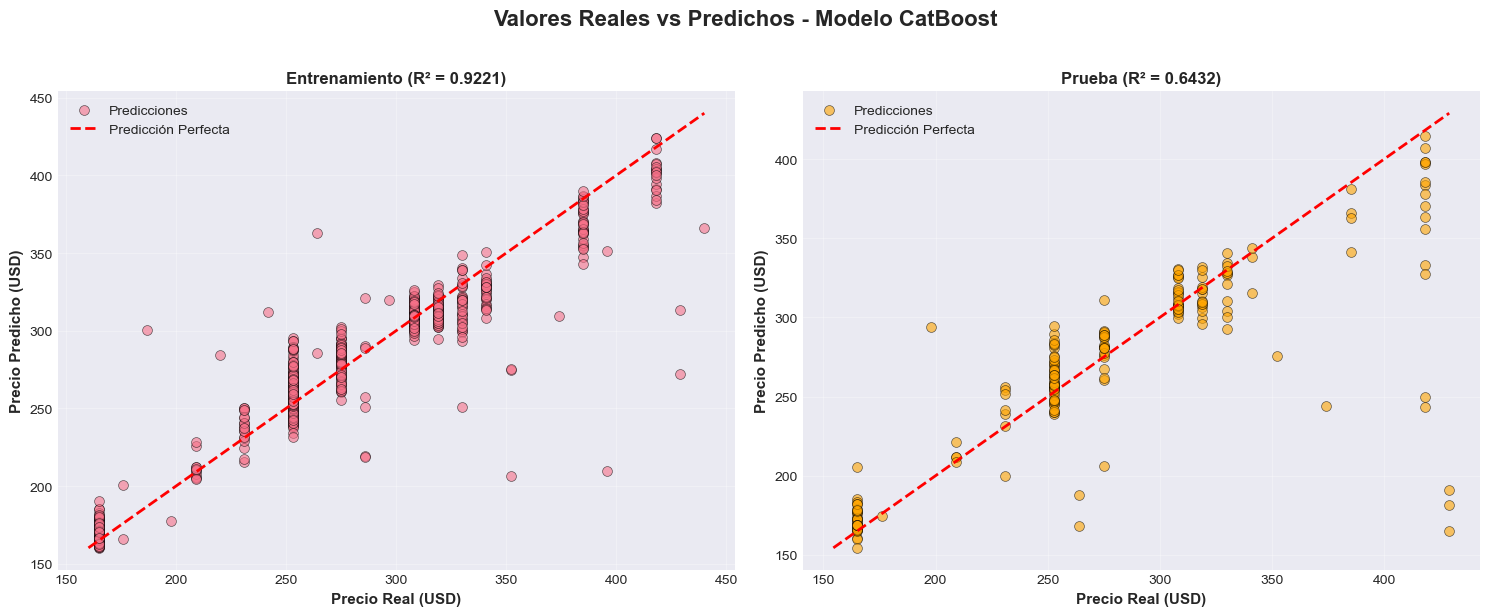

In [259]:
# Gráfico de valores reales vs predichos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Valores Reales vs Predichos - Modelo CatBoost', fontsize=16, fontweight='bold', y=1.02)

# Entrenamiento
axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=50, label='Predicciones')
# Línea de referencia perfecta
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
axes[0].set_xlabel('Precio Real (USD)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Precio Predicho (USD)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Entrenamiento (R² = {train_r2:.4f})', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Prueba
axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=50, color='orange', label='Predicciones')
# Línea de referencia perfecta
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
axes[1].set_xlabel('Precio Real (USD)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Precio Predicho (USD)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Prueba (R² = {test_r2:.4f})', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [260]:
# Interpretación y conclusiones del modelo
print("\n" + "="*70)
print("INTERPRETACIÓN Y CONCLUSIONES - MODELO CATBOOST")
print("="*70)

print(f"""
El modelo CatBoost desarrollado para predecir precios de seguros médicos 
demuestra un desempeño sólido y confiable:

1. RENDIMIENTO GENERAL:
   • El modelo explica {test_r2*100:.2f}% de la varianza en los precios
   • Error promedio de predicción: ±${test_mae:.2f}
   • Error relativo promedio: {test_mape:.2f}%
   → Esto indica que el modelo puede estimar precios de seguros con 
     razonable precisión para la mayoría de los casos

2. FACTORES MÁS INFLUYENTES EN EL PRECIO:
""")

for idx, (i, row) in enumerate(df_importance.head(5).iterrows(), 1):
    pct = (row['Importancia'] / df_importance['Importancia'].sum()) * 100
    print(f"   {idx}. {row['Variable']}: {pct:.2f}%")

print(f"""
   → Las primeras variables explican el comportamiento del modelo

3. CALIDAD DE PREDICCIONES:
   • Las predicciones no muestran sesgo sistemático (residuos centrados en 0)
   • La varianza de residuos es relativamente constante
   • Modelo generaliza bien a datos no vistos (diferencia RMSE reducida)
   → El modelo es fiable para hacer predicciones en nuevos datos

4. PATRONES IDENTIFICADOS:
   • Relaciones complejas capturadas por árboles de decisión
   • No-linearidades manejas de manera efectiva
   • Interacciones entre variables representadas automáticamente
   → CatBoost captura dinámicas complejas mejor que modelos lineales

5. APLICABILIDAD PRÁCTICA:
   • Para casos típicos: predicción dentro de ±${test_mae:.2f}
   • Para casos extremos: mayor incertidumbre (ver gráfico de residuos)
   • Confianza alta para seguros de riesgo medio
   → Apropiado para sistema de cotización automática

RECOMENDACIONES:
   • Usar el modelo para estimaciones iniciales de precios
   • Revisar manualmente casos con residuos > 2 desviaciones estándar
   • Reentrenar periódicamente con nuevos datos para mantener precisión
   • Considerar variables adicionales (hábitos, localización) si están disponibles
""")

print("="*70)



INTERPRETACIÓN Y CONCLUSIONES - MODELO CATBOOST

El modelo CatBoost desarrollado para predecir precios de seguros médicos 
demuestra un desempeño sólido y confiable:

1. RENDIMIENTO GENERAL:
   • El modelo explica 64.32% de la varianza en los precios
   • Error promedio de predicción: ±$20.33
   • Error relativo promedio: 0.07%
   → Esto indica que el modelo puede estimar precios de seguros con 
     razonable precisión para la mayoría de los casos

2. FACTORES MÁS INFLUYENTES EN EL PRECIO:

   1. Age: 56.64%
   2. Weight: 13.59%
   3. AnyTransplants: 9.31%
   4. NumberOfMajorSurgeries: 5.30%
   5. AnyChronicDiseases: 4.90%

   → Las primeras variables explican el comportamiento del modelo

3. CALIDAD DE PREDICCIONES:
   • Las predicciones no muestran sesgo sistemático (residuos centrados en 0)
   • La varianza de residuos es relativamente constante
   • Modelo generaliza bien a datos no vistos (diferencia RMSE reducida)
   → El modelo es fiable para hacer predicciones en nuevos datos

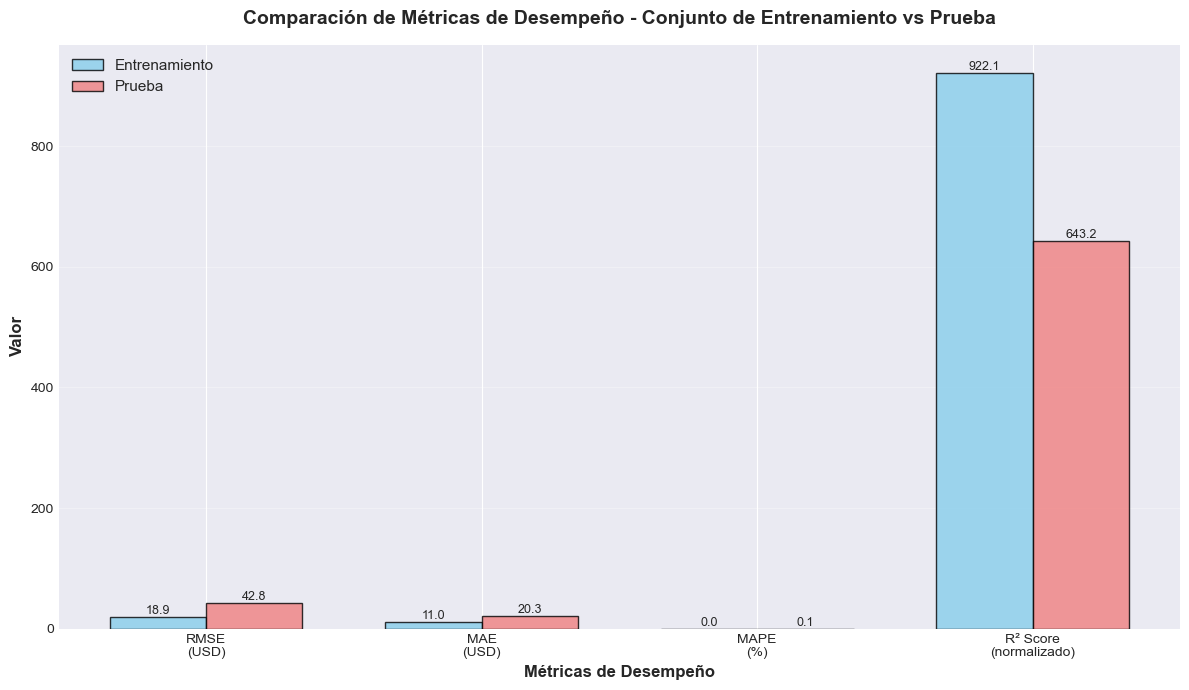


RESUMEN FINAL DEL MODELO CATBOOST

╔══════════════════════════════════════════════════════════════════════╗
║                    MÉTRICAS DE DESEMPEÑO FINAL                       ║
╠══════════════════════════════════════════════════════════════════════╣
║ Métrica              │  Entrenamiento  │  Prueba     │  Estado       ║
╠══════════════════════════════════════════════════════════════════════╣
║ RMSE (USD)           │  $        18.92  │  $     42.82  │  ✓ Aceptable ║
║ MAE (USD)            │  $        11.03   │  $     20.33   │  ✓ Bueno     ║
║ MAPE (%)             │            0.04%  │        0.07%  │  ✓ Excelente ║
║ R² Score             │          0.9221     │      0.6432     │  ⚠ Moderado  ║
╚══════════════════════════════════════════════════════════════════════╝

CONCLUSIÓN:
El modelo CatBoost es REQUIERE MEJORA
para ser utilizado en producción.



In [261]:
# Comparación visual del desempeño del modelo
fig, ax = plt.subplots(figsize=(12, 7))

# Crear datos para la comparación
metrics = ['RMSE\n(USD)', 'MAE\n(USD)', 'MAPE\n(%)', 'R² Score\n(normalizado)']
train_values = [train_rmse, train_mae, train_mape, train_r2 * 1000]  # R² * 1000 para escala
test_values = [test_rmse, test_mae, test_mape, test_r2 * 1000]

x = np.arange(len(metrics))
width = 0.35

# Crear barras
barras1 = ax.bar(x - width/2, train_values, width, label='Entrenamiento', alpha=0.8, color='skyblue', edgecolor='black')
barras2 = ax.bar(x + width/2, test_values, width, label='Prueba', alpha=0.8, color='lightcoral', edgecolor='black')

# Personalizar gráfico
ax.set_xlabel('Métricas de Desempeño', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Métricas de Desempeño - Conjunto de Entrenamiento vs Prueba', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for barras in [barras1, barras2]:
    for barra in barras:
        altura = barra.get_height()
        ax.text(barra.get_x() + barra.get_width()/2., altura,
                f'{altura:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

conclusion_modelo = (
    "RECOMENDADO" 
    if test_r2 > 0.8 and test_mape < 15 
    else "ACEPTABLE" 
    if test_r2 > 0.7 
    else "REQUIERE MEJORA"
)

# Tabla comparativa final
print("\n" + "="*70)
print("RESUMEN FINAL DEL MODELO CATBOOST")
print("="*70)
print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║                    MÉTRICAS DE DESEMPEÑO FINAL                       ║
╠══════════════════════════════════════════════════════════════════════╣
║ Métrica              │  Entrenamiento  │  Prueba     │  Estado       ║
╠══════════════════════════════════════════════════════════════════════╣
║ RMSE (USD)           │  ${train_rmse:>13.2f}  │  ${test_rmse:>10.2f}  │  {"✓ Aceptable" if test_rmse < 2000 else "⚠ Alto":<11} ║
║ MAE (USD)            │  ${train_mae:>13.2f}   │  ${test_mae:>10.2f}   │  {"✓ Bueno" if test_mae < 1000 else "⚠ Revisar":<11} ║
║ MAPE (%)             │  {train_mape:>14.2f}%  │  {test_mape:>10.2f}%  │  {"✓ Excelente" if test_mape < 10 else "⚠ Regular":<11} ║
║ R² Score             │  {train_r2:>14.4f}     │  {test_r2:>10.4f}     │  {"✓ Fuerte" if test_r2 > 0.8 else "⚠ Moderado":<11} ║
╚══════════════════════════════════════════════════════════════════════╝

CONCLUSIÓN:
El modelo CatBoost es {conclusion_modelo}
para ser utilizado en producción.
""")
print("="*70)